# Init process: import libraries, load datasets and evaluate data for next phases

Import ncessary libraries.

In [106]:
import pandas as pd
from pandas import DataFrame
import datetime
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import copy
import os
import math
from os import listdir
from datetime import date,timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.metrics import max_error
from sklearn.cluster import KMeans

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.stats.outliers_influence as st_inf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import decomposition, datasets

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings

from pyramid.arima import auto_arima

%matplotlib inline
%run Utilities.ipynb
warnings.filterwarnings("ignore")



Load dataset about total deaths, new deaths, total cases and new cases.

In [2]:
#load full dataset of coronavirus from internet
df_all_data__ = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")
#rename columns with more meaningful name
df_all_data__.rename(columns={"location": "Country","date":"Date", "new_cases":"New cases",
                            "new_deaths":"New deaths","total_cases":"Total cases", 
                            "total_deaths":"Total deaths"}, inplace = True)
df_all_data__.tail()

,Date,Country,New cases,New deaths,Total cases,Total deaths
19600,2020-05-22,Zimbabwe,3,0,51,4
19601,2020-05-23,Zimbabwe,5,0,56,4
19602,2020-05-24,Zimbabwe,0,0,56,4
19603,2020-05-25,Zimbabwe,0,0,56,4
19604,2020-05-26,Zimbabwe,0,0,56,4


Load population dataset. The dataset is updated with 2020 data. 
It has been downloaded from:
https://www.kaggle.com/tanuprabhu/population-by-country-2020.

It is currently saved locally.
The dataset contains for each country the number of inhabitants. This dataset is used later to plot covid-19 deaths and cases basing on number of inhabitants.

In [3]:
#load population dataset keeping only the necessary columns 
#(countries and number of inhabitants) renaiming them
df_population = pd.read_csv("../COVID19_analysis/dataset/population_by_country_2020.csv")
df_population = df_population[['Country (or dependency)','Population (2020)']]
df_population.drop_duplicates(inplace = True)
df_population.rename(columns={"Country (or dependency)": "Country",
                            "Population (2020)":"Population"}, inplace = True)
df_population.head()

,Country,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


Load lockdown dataset. The dataset has been downloaded from:
https://www.kaggle.com/jcyzag/covid19-lockdown-dates-by-country#countryLockdowndates.csv.

It is currently saved locally.
It contains the following columns:
<ul>
<li>country</li>
<li>province of the country</li>
<li>date in which the lockdown has been put in place</li>
<li>type of lockdown (full, partial or none)</li>
<li>reference (source of the data).</li>
</ul>

In [4]:
#load lockdown dataset
df_lockdown = pd.read_csv("../COVID19_analysis/dataset/countryLockdowndates.csv")

#rename column relative to country
df_lockdown.rename(columns={"Country/Region": "Country","Date":"Beginning Date"}, inplace = True)
#convert string date format from 'dd/mm/yyyy' to 'yyyy-mm-dd'
df_lockdown['Beginning Date'] = pd.to_datetime(df_lockdown['Beginning Date'])
#rename country value from 'US' to 'United States' where needed
df_lockdown['Country'] = df_lockdown['Country'].apply(lambda x : 'United States' if x == 'US' else x)
#delete 'Reference column'
df_lockdown.drop('Reference', axis = 1, inplace = True)
#if value in 'Province' column is not present, 
#replace it with value in 'Country' column
df_lockdown.Province.fillna(df_lockdown.Country, inplace = True)
#keep only the country where the value in the Country column is equal 
#to the value in the Province column. In this way, it eliminates the
#rows reguarding colonies
df_lockdown = df_lockdown[df_lockdown.Province == df_lockdown.Country]
#drop the Province column because it is not necessary
df_lockdown.drop('Province', axis = 1, inplace = True)
df_lockdown.head()

,Country,Beginning Date,Type
0,Afghanistan,2020-03-24,Full
1,Albania,2020-03-08,Full
2,Algeria,2020-03-24,Full
3,Andorra,2020-03-16,Full
4,Angola,2020-03-24,Full


Load population density dataset. The dataset is downloaded from:
https://www.kaggle.com/fernandol/countries-of-the-world#countries%20of%20the%20world.csv

In [5]:
#load dataset
pd.set_option('mode.chained_assignment', None)
df_population_density_ = pd.read_csv("../COVID19_analysis/dataset/population_density.csv")
df_population_density = df_population_density_[['Country','Pop. Density (per sq. mi.)']]
df_population_density.rename(columns = {'Pop. Density (per sq. mi.)': 'Population density'}, inplace = True)
#trim country value because original dataset has a space at the end
df_population_density['Country'] = df_population_density['Country'].apply(lambda x : x.strip())
df_population_density.head()

,Country,Population density
0,Afghanistan,48.0
1,Albania,124.6
2,Algeria,13.8
3,American Samoa,290.4
4,Andorra,152.1


Merge coronavirus dataset and population dataset.

In [6]:
df_all_data_ =df_all_data__.copy()
df_all_data_ = pd.merge (left = df_all_data_, right = df_population, on = 'Country')
df_all_data_ = pd.merge (left = df_all_data_, right = df_population_density, on = 'Country')
df_all_data_['Date'] = pd.to_datetime(df_all_data_['Date'])
df_all_data_.head()

,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density
0,2019-12-31,Afghanistan,0,0,0,0,38928346,48.0
1,2020-01-01,Afghanistan,0,0,0,0,38928346,48.0
2,2020-01-02,Afghanistan,0,0,0,0,38928346,48.0
3,2020-01-03,Afghanistan,0,0,0,0,38928346,48.0
4,2020-01-04,Afghanistan,0,0,0,0,38928346,48.0


Evaluate number of cases and deaths per million of inhabitants and store the information in new columns of the full dataset.

In [7]:
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'New cases',
                                            'New cases per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'Total cases',
                                            'Total cases per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'New deaths',
                                            'New deaths per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'Total deaths',
                                            'Total deaths per million of inhabitants')
df_all_data_.tail()

,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density,New cases per million of inhabitants,Total cases per million of inhabitants,New deaths per million of inhabitants,Total deaths per million of inhabitants
16830,2020-05-22,Zimbabwe,3,0,51,4,14862924,31.3,0.201845,3.431357,0.0,0.269126
16831,2020-05-23,Zimbabwe,5,0,56,4,14862924,31.3,0.336408,3.767765,0.0,0.269126
16832,2020-05-24,Zimbabwe,0,0,56,4,14862924,31.3,0.000000,3.767765,0.0,0.269126
16833,2020-05-25,Zimbabwe,0,0,56,4,14862924,31.3,0.000000,3.767765,0.0,0.269126
16834,2020-05-26,Zimbabwe,0,0,56,4,14862924,31.3,0.000000,3.767765,0.0,0.269126


Add lockdown information in the full dataset. For each row, create a new column where if in the country for that date was not present the lockdown, the value is set to 0, if the lockdown is partial set a value of 1, if the lockdown is full, set the value to 2. 

In [8]:
#make a copy of the full dataset
#merge lockdown dataset with full dataset
df_all_data = df_all_data_.copy()
df_all_data = df_all_data.merge(df_lockdown, on='Country', how='left')

#create a new column setting an initial default value of -1.
#This value has no meaning. Its only a "jolly" value that evidences
#that the value hano not been set yet
df_all_data['Lockdown state'] = -1

#set a correct value for each row in the full dataset that depends
#on the lockdown type in that particula date for each country
for i in range(len(df_all_data)):
    if(df_all_data.iloc[i]['Type'] == 'None'):
        df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 0
    elif(df_all_data.iloc[i]['Date'] < df_all_data.iloc[i]['Beginning Date']):
        df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 0
    else:
        if(df_all_data.iloc[i]['Type'] == 'Full'):
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 2
        elif(df_all_data.iloc[i]['Type'] == 'Partial'):
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 1
        else:
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = -2

#drop Type column because it is not usefull now
del df_all_data['Type']

df_all_data.head()

,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density,New cases per million of inhabitants,Total cases per million of inhabitants,New deaths per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state
0,2019-12-31,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
1,2020-01-01,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
2,2020-01-02,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
3,2020-01-03,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
4,2020-01-04,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0


Associate a color to each country that will be used later when plotting the data

In [9]:
colorMap(df_all_data.Country.unique(),0)

# Data visualization

### Analysis by country without considering the number of inhabitants

Firstly, it would be interesting to compare the growth about the number of deaths and cases of some countries starting from a specific point, meant as a common starting point, for a better comparison. Next steps are used to estabilish which is the starting point.

In the first step it is necessary to retrieve what the top ten countries for number of deaths are.

In [10]:
#create a copy of the dataset keeping the necessary columns
df_total_deaths = df_all_data[['Country','Total deaths']].copy()
#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths = df_total_deaths.groupby('Country').max()
df_group_total_deaths.sort_values(by = 'Total deaths',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_deaths = df_group_total_deaths.iloc[0:10]
top_10_total_deaths.reset_index(inplace = True)
#print data of all the world deaths
print("World number of deaths:", df_group_total_deaths['Total deaths'].sum(), end ="\n\n")
top_10_total_deaths

World number of deaths: 346780



,Country,Total deaths
0,United States,98220
1,United Kingdom,36914
2,Italy,32877
3,Spain,28752
4,France,28432
5,Brazil,23473
6,Belgium,9312
7,Germany,8302
8,Mexico,7633
9,Iran,7451


Plot the total number of deaths, day by day, of the top 10 countries, focusing on a range between 0 and 200 cases.

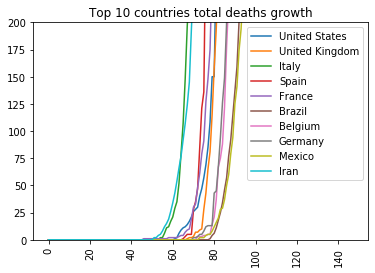

In [11]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth',
                            0, 200)

It is possible to set the starting point to 50 deaths, and this will be the common starting point for comparing the data.

Print data of the top 10 countries for number of deaths and plot the growth starting from the first 50 confirmed deaths.

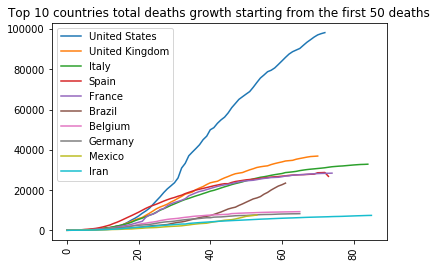

In [12]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth starting from the first 50 deaths',
                            50)

It is intersting to see how the grow in United States is faster than in the other countries. Now, let's plot the data with a logarithmic scale to better view the other countries. The starting point is set to 1.69, that correspond to 50 deaths in the normal scale

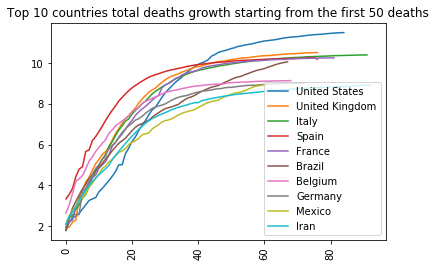

In [13]:
df_total_deaths_log = df_total_deaths.copy()
df_total_deaths_log['Total deaths'] = df_total_deaths_log['Total deaths'].replace(0, 1)
df_total_deaths_log['Total deaths'] = np.log(df_total_deaths_log['Total deaths'])
df_total_deaths_log

#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_log, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth starting from the first 50 deaths',
                            1.69)

This last graph help to understand how the value of total deaths is stabilizing for many countries of the top ten list but South America countries such as Brazil and Mexico are still growing at a high rate 

The same procedure is used for confirmed cases.
First, retrieve information about top 10 countries for total number of cases.

In [14]:
#create a copy of the dataset keeping the necessary columns
df_total_cases = df_all_data[['Country','Total cases']].copy()
#get the maximum value of each country and sort the data in descendent way
df_group_total_cases = df_total_cases.groupby('Country').max()
df_group_total_cases.sort_values(by = 'Total cases',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_cases = df_group_total_cases.iloc[0:10]
top_10_total_cases.reset_index(inplace = True)
#print data of all the world deaths
print("World number of cases:", df_group_total_cases['Total cases'].sum(), end ="\n\n")
top_10_total_cases

World number of cases: 5423741



,Country,Total cases
0,United States,1662302
1,Brazil,374898
2,Russia,353427
3,United Kingdom,261184
4,Spain,235772
5,Italy,230158
6,Germany,179002
7,Turkey,157814
8,India,145380
9,France,145279


Plot the total number of cases, day by day, of the top 10 countries, focusing on a range between 0 and 200 cases.

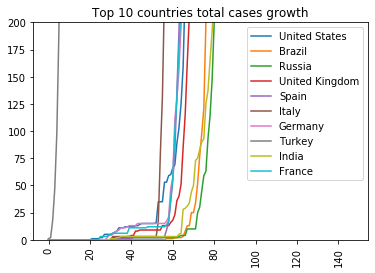

In [15]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_10_total_cases['Country'], 'Total cases',
                            'Top 10 countries total cases growth',
                            0, 200)

Because of a stabilization period in many countries around about 25 cases, this time, the starting point is set to 25 cases.

Print data of the top 10 countries for number of cases and plot the growth starting from the first 25 confirmed case.

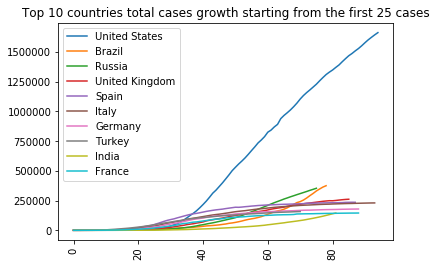

In [16]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_10_total_cases['Country'],'Total cases',
                            'Top 10 countries total cases growth starting from the first 25 cases',
                            25)

### Analysis by country considering the number of inhabitants

As done before, firstly, print data of top ten countries for total deaths.

In [17]:
#create a copy of the dataset
df_total_deaths_x_million = df_all_data[['Country',
                                         'Total deaths per million of inhabitants']].copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths_x_million = df_total_deaths_x_million.groupby('Country').max()
df_group_total_deaths_x_million.sort_values(by = 'Total deaths per million of inhabitants',ascending = False, inplace = True)


#loc the first 10 rows
top_10_total_deaths_x_million = df_group_total_deaths_x_million.iloc[0:10]
top_10_total_deaths_x_million.reset_index(inplace = True)
top_10_total_deaths_x_million

,Country,Total deaths per million of inhabitants
0,San Marino,1237.806136
1,Belgium,803.477387
2,Andorra,660.066007
3,Spain,614.953193
4,Italy,543.764590
5,United Kingdom,543.764458
6,France,435.582514
7,Sweden,398.939923
8,Netherlands,340.241818
9,Ireland,325.246983


Plot data day by day of the top 10 countries to try to detect a common starting point for comparing the growth focusing on a range between 0 and 20 cases per million of inhabitants.

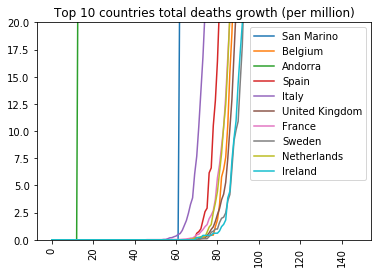

In [18]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total deaths per million of inhabitants',
                            'Top 10 countries total deaths growth (per million)',
                            0, 20)

For some countries, such as Andorra and San Marino, there is not a slow growth but they have a very fast increase. A part these, it is possible to consider, as a common starting point, a value of 2.5.

Plot the growth starting from the point where the rate was upper than 2.5.

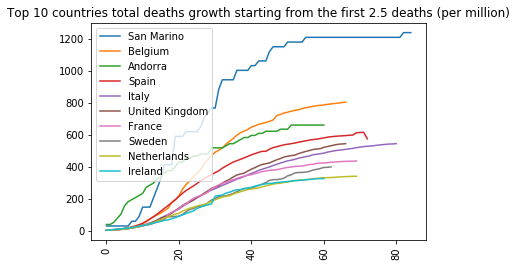

In [19]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total deaths per million of inhabitants',
                            'Top 10 countries total deaths growth starting from the first 2.5 deaths (per million)',
                            2.5)

The growth is almost linear for the top 10 countries.

Print data of the top 10 countries for number of cases per million.

In [20]:
#create a copy of the dataset
df_total_cases_x_million = df_all_data[['Country',
                                         'Total cases per million of inhabitants']].copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_cases_x_million = df_total_cases_x_million.groupby('Country').max()
df_group_total_cases_x_million.sort_values(by = 'Total cases per million of inhabitants',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_cases_x_million = df_group_total_cases_x_million.iloc[0:10]
top_10_total_cases_x_million.reset_index(inplace = True)
top_10_total_cases_x_million

,Country,Total cases per million of inhabitants
0,San Marino,19628.068728
1,Qatar,15780.688519
2,Andorra,9875.105158
3,Luxembourg,6378.818425
4,Singapore,5462.928492
5,Bahrain,5389.712472
6,Iceland,5286.555329
7,Kuwait,5143.808638
8,Spain,5042.735953
9,United States,5022.020201


As done before, plot the growth to detect a common comparison starting point focusing on a range between 0 and 20 cases per million of inhabitants.

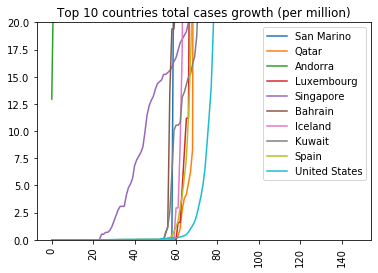

In [21]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total cases per million of inhabitants',
                            'Top 10 countries total cases growth (per million)',
                            0, 20)

The growth increases very fast. A common starting point for comparison could be 2.5 cases per million of inhabitants.

Plot the growth starting from the point where the rate was upper than 2.5 cases per million of inhabitants.

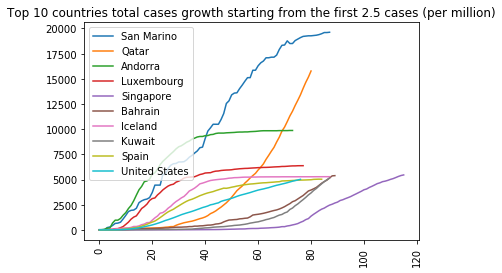

In [22]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total cases per million of inhabitants',
                            'Top 10 countries total cases growth starting from the first 2.5 cases (per million)',
                            2.5)

It is interesting to see how small countries have a higher concentration of deaths and cases and thye occupies the first places in number of cases and deaths in this ranking. It is now possible to find out if at a first glance there is a correlation between population density and the virus spread. Following, the population density distribution. 

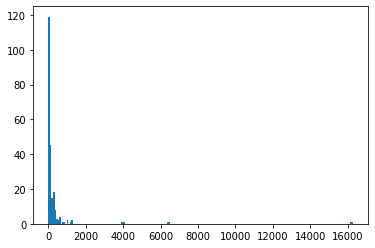

In [23]:
#plot population density
plt.hist(df_population_density['Population density'], bins=200) 
plt.show()

To better visualize the distribution, a cut is placed at 1500 in the plot visualization. There are a few values upper than that. 

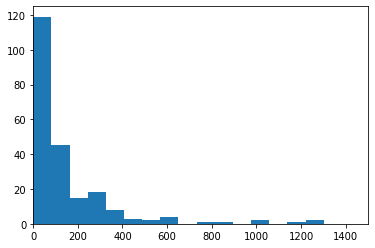

In [24]:
#plot population density
plt.hist(df_population_density['Population density'], bins=200) 
plt.xlim(0, 1500)
plt.show()

Print also some statistical information of these data.

In [25]:
df_population_density['Population density'].describe()

count      227.000000
mean       379.047137
std       1660.185825
min          0.000000
25%         29.150000
50%         78.800000
75%        190.150000
max      16271.500000
Name: Population density, dtype: float64

It is now necessary to print the population density of the top 10 countries for total number of deaths and for total number of deaths per million of inhabitants. Then we can use the mean value of the population density to compare the two groups.

In [26]:
print('Population density of top 10 countries for number of deaths:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of deaths:

            Country  Population density
27           Brazil                22.1
214   United States                31.0
96             Iran                41.7
135          Mexico                54.5
190           Spain                80.0
69           France               111.3
101           Italy               193.0
76          Germany               230.9
213  United Kingdom               247.6
19          Belgium               340.0

Mean value: 135.20999999999998


In [27]:
print('Population density of top 10 countries for number of deaths per million of inhabitants:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths_x_million['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths_x_million['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of deaths per million of inhabitants:

            Country  Population density
195          Sweden                20.0
98          Ireland                57.8
190           Spain                80.0
69           France               111.3
4           Andorra               152.1
101           Italy               193.0
213  United Kingdom               247.6
19          Belgium               340.0
146     Netherlands               397.1
177      San Marino               479.5

Mean value: 207.84


The same computation is done for the total number of cases.

In [28]:
print('Population density of top 10 countries for number of cases:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of cases:

            Country  Population density
169          Russia                 8.4
27           Brazil                22.1
214   United States                31.0
190           Spain                80.0
206          Turkey                90.2
69           France               111.3
101           Italy               193.0
76          Germany               230.9
213  United Kingdom               247.6
94            India               333.2

Mean value: 134.76999999999998


In [29]:
print('Population density of top 10 countries for number of cases per million of inhabitants:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases_x_million['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases_x_million['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of cases per million of inhabitants:

           Country  Population density
93         Iceland                 2.9
214  United States                31.0
166          Qatar                77.4
190          Spain                80.0
111         Kuwait               135.7
4          Andorra               152.1
121     Luxembourg               183.5
177     San Marino               479.5
15         Bahrain              1050.5
184      Singapore              6482.2

Mean value: 867.4799999999999


In this last computation there is Singapore that can be considered as an "outlier" for the computation of the mean value. It is possible to recompute the mean value without considering it.

In [30]:
top_10_without_singapore = top_10_total_cases_x_million[top_10_total_cases_x_million['Country'] != 'Singapore']
print('\nNew mean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_without_singapore['Country'].to_list())]['Population density'].mean())


New mean value: 243.62222222222226


Because in the top 10 countries of the two lists, a part a couple of coutries, the max value is around 500 and basing on the density population distribution most of the values are under 500, in the next step the density population dataset is filtered to remove all the data over 500. Next, statistical description is computed to better explain the impact of population density on virus spread.

In [31]:
df_filtered_population_density = df_population_density.loc[df_population_density['Population density'] < 500]
print("Statistical description of population density under a value of 500")
df_filtered_population_density.describe()

Statistical description of population density under a value of 500


,Population density
count,209.000000
mean,106.803828
std,108.814715
min,0.000000
25%,26.700000
50%,66.900000
75%,142.700000
max,496.000000


Comparing mean values of the two lists, for the number of deaths, there is a slighty difference between the top 10 countries for number of deaths and the top 10 countries for number of deaths per million of inhabitants in respect of the population density. So, the initial hypotesis that the population density could have an impact in the virus spread, is not verified.
About the difference in the confirmed cases, although the difference is more evident, it is not significant if it is taken in consideration that the standard deviation  of the population density in the filtered data is 108. The difference between the two means value is about 150 that is a similar value compared to the standard deviation. At a first glance, it is safe to say that there is not a strong correlation between the virus spread and the population density. 

## Focus on the number of new deaths an new cases.

Print data of the top ten day/country for new deaths

In [32]:
#copy the dataframe
df_new_deaths = df_all_data[['Date','Country','New deaths']].copy()
#delete the row regarding the entire world
df_new_deaths = df_new_deaths[df_new_deaths['Country'] != 'World']
#sort the data in descending order and print the top 10 rows
df_new_deaths.sort_values(by = 'New deaths', ascending = False, inplace = True)
df_new_deaths.head(10)

,Date,Country,New deaths
16218,2020-04-16,United States,4928
16220,2020-04-18,United States,3770
16226,2020-04-24,United States,3179
16232,2020-04-30,United States,2611
16224,2020-04-22,United States,2524
16217,2020-04-15,United States,2408
16239,2020-05-07,United States,2353
16219,2020-04-17,United States,2299
16240,2020-05-08,United States,2239
16228,2020-04-26,United States,2172


Evaluate the moving average for new deaths taking in consideration a period of 10 days.

In [33]:
#copy di full dataset
df_ = df_all_data.copy()
#create a matrix of the new deaths, in this way, each column represent
#a country and the index row are the date. In the corresponding row 
#there is the number of new deaths for the row date
df_matrix_new_deaths = get_matrix_dataset(df_, 'New deaths')
df_matrix_new_deaths.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
2020-05-22,6,0,7,0,0,0,13,3,0,0,...,338,1263,0,0,0,0,0,4,0,0
2020-05-23,12,0,7,0,0,0,17,4,0,1,...,351,1305,0,0,0,0,0,0,0,0
2020-05-24,11,0,10,0,0,0,12,3,0,1,...,282,1080,2,0,0,0,0,6,0,0
2020-05-25,2,1,8,0,1,0,7,4,0,0,...,118,633,0,0,0,0,0,3,0,0
2020-05-26,1,0,9,0,0,0,15,6,0,0,...,121,500,0,0,0,0,0,3,0,0


In [34]:
#evaluate the moving average of the new cases matrix
df_new_deaths_moving_average_ = df_matrix_new_deaths.copy()
df_new_deaths_moving_average_ = evaluate_moving_average(df_new_deaths_moving_average_, 10)
df_new_deaths_moving_average_.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-22,5,0,5,0,0,0,8,1,0,0,...,508,1652,0,0,0,0,0,0,0,0
2020-05-23,5,0,5,0,0,0,8,1,0,0,...,455,1561,0,0,0,0,0,0,0,0
2020-05-24,5,0,5,0,0,0,8,1,0,0,...,456,1600,0,0,0,0,0,0,0,0
2020-05-25,4,0,5,0,0,0,8,1,0,0,...,474,1645,0,0,0,0,0,1,0,0
2020-05-26,4,0,6,0,0,0,9,1,0,0,...,488,1697,0,0,0,0,0,1,0,0


It is now interesting to see the evaluation, basing on the moving average of the new deaths, about the number of days between the day in which the lockdow has been set and when the peak in number of deaths has been reached. This evaluation is displayed for the top 10 countries for number of deaths. The number of days between the lockdown date and the peak is showed inside each graph.

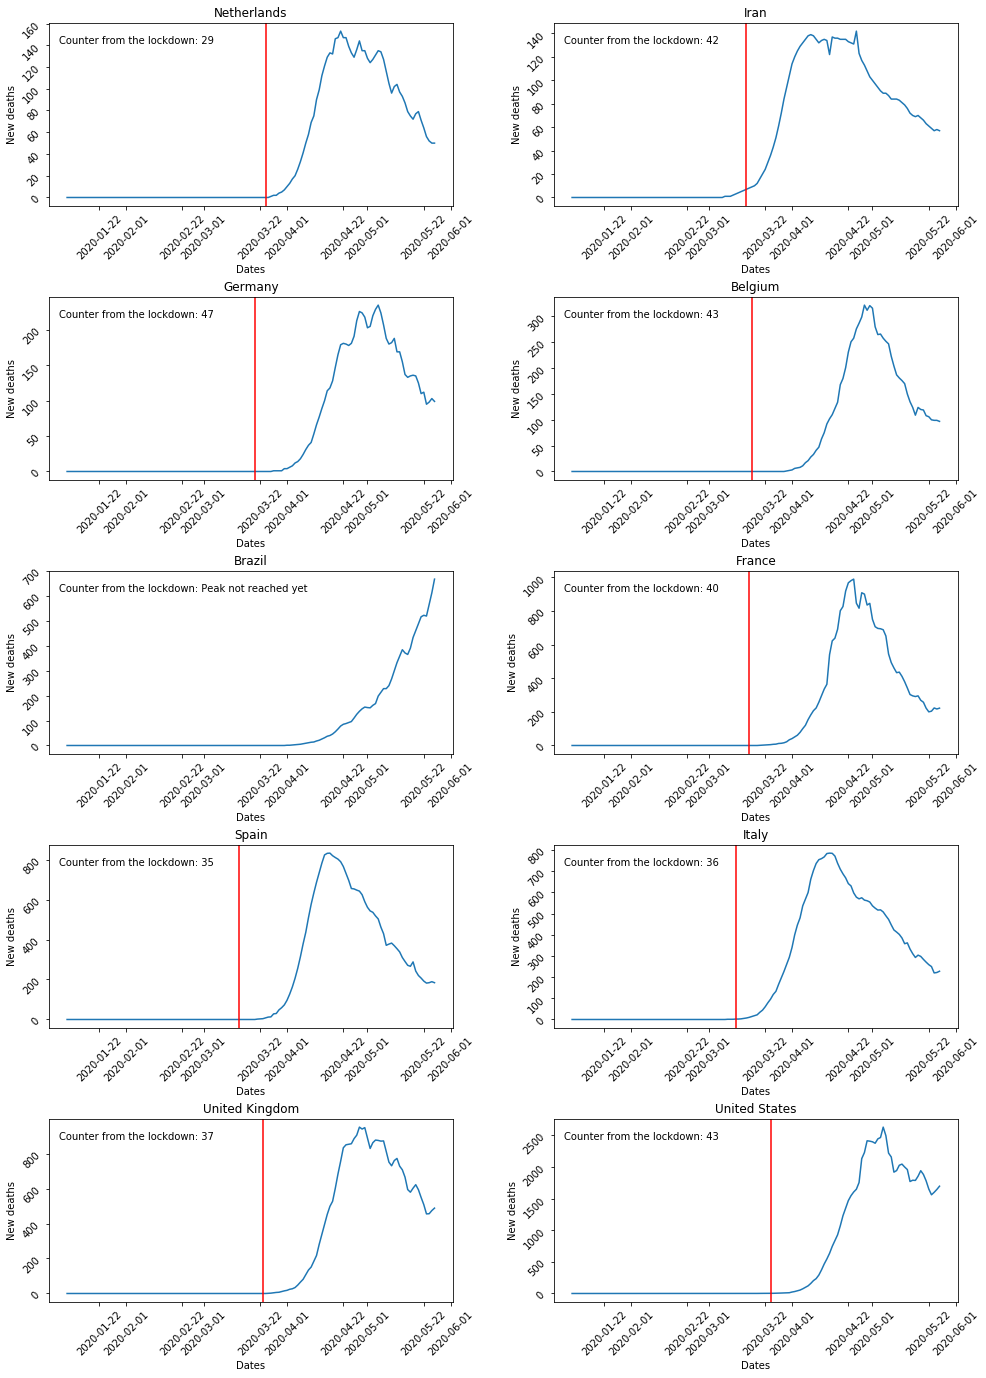

In [35]:
#calculating the top ten for deaths making the sum of all the deaths and plotting it
max_deaths=df_new_deaths_moving_average_.sum(axis = 0, skipna = True)
top_ten_new_deaths_moving_average=max_deaths.sort_values()[-10:].index

plotWithLockdown(top_ten_new_deaths_moving_average,df_lockdown,df_new_deaths_moving_average_,'New deaths')


Print data of the top ten day/country for new cases

In [36]:
#copy the dataframe
df_new_cases = df_all_data[['Date','Country','New cases']].copy()
#delete the row regarding the entire world
df_new_cases = df_new_cases[df_new_cases['Country'] != 'World']
df_new_cases.sort_values(by = 'New cases', ascending = False, inplace = True)
df_new_cases.head(10)

,Date,Country,New cases
16228,2020-04-26,United States,48529
16224,2020-04-22,United States,37289
16213,2020-04-11,United States,35527
16207,2020-04-05,United States,34272
16234,2020-05-02,United States,33955
16212,2020-04-10,United States,33901
16211,2020-04-09,United States,33323
16221,2020-04-19,United States,32922
16206,2020-04-04,United States,32425
16219,2020-04-17,United States,31667


Evaluate the moving average for new cases taking in consideration a period of 10 days.

In [37]:
#copy di full dataset
df_ = df_all_data.copy()
#create a matrix of the new deaths, in this way, each column represent
#a country and the index row are the date. In the corresponding row 
#there is the number of new cases for the row date
df_matrix_new_cases = get_matrix_dataset(df_, 'New cases')
df_matrix_new_cases.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
2020-05-22,531,5,186,0,6,0,648,335,0,2,...,2615,25434,3,56,58,0,0,13,34,3
2020-05-23,540,12,190,0,2,0,718,322,0,14,...,3287,24147,4,72,62,0,0,12,54,5
2020-05-24,782,8,195,0,0,0,704,374,0,11,...,2959,21236,11,54,0,0,0,7,0,0
2020-05-25,584,9,193,1,9,0,723,359,0,3,...,2405,20568,5,32,177,1,0,10,0,0
2020-05-26,591,6,197,0,0,0,552,452,0,9,...,1625,19064,18,97,56,1,0,15,0,0


In [38]:
#evaluate the moving average of the new cases matrix
df_new_cases_moving_average_ = df_matrix_new_cases.copy()
df_new_cases_moving_average = evaluate_moving_average(df_new_cases_moving_average_, 20)
df_new_cases_moving_average.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-22,82,17,112,7,0,0,122,56,0,26,...,5049,28413,9,71,7,0,0,0,3,1
2020-05-23,89,17,116,6,0,0,119,59,0,23,...,4923,28691,9,64,8,0,0,0,3,1
2020-05-24,93,17,119,5,0,0,123,63,0,23,...,4899,28774,9,63,8,0,0,0,3,1
2020-05-25,101,16,124,5,0,0,124,67,0,21,...,4898,28772,9,57,8,0,0,0,3,0
2020-05-26,109,16,128,4,0,0,122,69,0,20,...,4835,28555,8,51,8,0,0,0,4,0


The same evaluation done before for the number of deaths, is now done for the new cases.

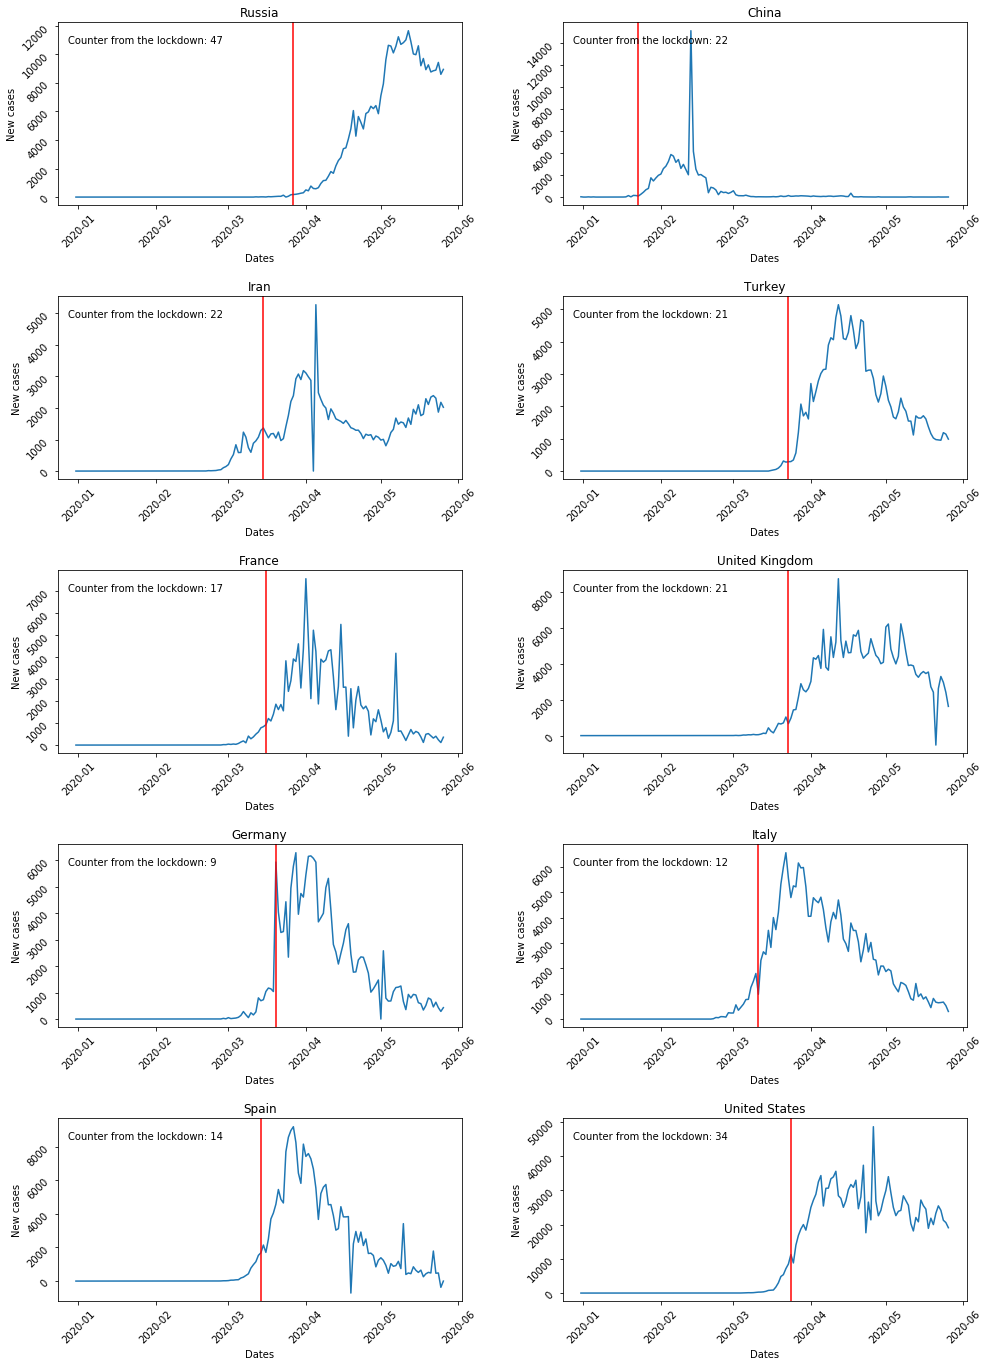

In [39]:
max_cases=df_new_cases_moving_average.sum(axis = 0, skipna = True)
top_ten_new_cases_moving_average=max_cases.sort_values()[-10:].index

plotWithLockdown(top_ten_new_cases_moving_average,df_lockdown,df_new_cases_moving_average_,'New cases')

An immediate consideration that can be done looking at these final data is both for the new cases graphs of the top 10 countries and for the number of deaths the peak is always passed, the average period of the new cases to get the peak is faster than the corresponding value of the number of deaths. A hypotesis could be that once the virus is identified in a country, there are a lot of cases already present in that country. The lockdown is a containtment action that allow to block the spread so, in a few days, the number of new cases decrease. Unlike this, the deaths come later because the virus doesn't kill a person immediately. It needs many days to make it happen. The only countries where the peak is not passed is Brazil, where since now no lockdown measures has been put in place.

Another consideration that can be highlighted is that the graph about deaths is more linear than the number of cases. This could be because the number of cases is also influenced by the number of swabs executed in each day. Unfortunately this data are not available for al the countries and often are not reliable.

## Analysis of the percentage of growth

In this section, an evaluation on the growth rate for the total number of deaths and cases has been computed. The growth rate is evaluated considering the difference in terms of total number of deaths or total number of cases between two consecutive days divided the total number of deaths or cases that the desease has generated for a particular country. Then the top 5 countries data are displayed.

Create a dataframe with the total deaths grow rate for each country day by day.

In [40]:
df_total_deaths = df_all_data[['Date','Country','Total deaths']].copy()
death_growth_rate = evaluateGrowthRate(df_total_deaths, 1, 'Total deaths')

Plot the death grow rate of the top 5 countries for deaths.

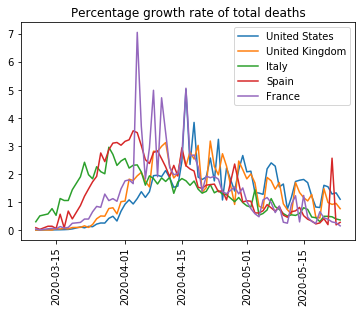

In [41]:
#get the list of the top 5 countries
top_5_death_countries_list = top_10_total_deaths['Country'].to_list()[0:5]
#select the growth rate only of the countries list
some_countries_deaths_growth = death_growth_rate[top_5_death_countries_list]

some_countries_deaths_growth=some_countries_deaths_growth[some_countries_deaths_growth>0]
some_countries_deaths_growth=some_countries_deaths_growth.dropna()
for country in top_5_death_countries_list:
    plt.plot(some_countries_deaths_growth[country], label = country)
plt.legend()
plt.xticks(rotation = 90)
plt.title("Percentage growth rate of total deaths")
plt.show()

Create a dataframe with the total cases grow rate for each country day by day.

In [42]:
df_total_cases = df_all_data[['Date','Country','Total cases']].copy()
case_growth_rate = evaluateGrowthRate(df_total_cases, 1, 'Total cases')

Plot the grow rate of the top 5 countries for number of cases.

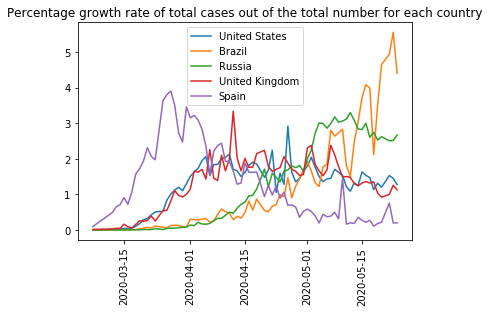

In [43]:
#get the list of the top 5 countries
top_5_case_countries_list = top_10_total_cases['Country'].to_list()[0:5]
#select the growth rate only of the countries list
some_countries_cases_growth = case_growth_rate[top_5_case_countries_list]
some_countries_cases_growth=some_countries_cases_growth[some_countries_cases_growth > 0]
some_countries_cases_growth=some_countries_cases_growth.dropna()
for country in top_5_case_countries_list:
    plt.plot(some_countries_cases_growth[country], label = country)
plt.legend()
plt.xticks(rotation = 90)
plt.title("Percentage growth rate of total cases out of the total number for each country")
plt.show()

In this last graphs it is possible to see which are the days, for the top 5 countries, more critical. Obviously, the real problem is in the days after each peak, where the emergency must be managed in term of cases (hospital) or deaths (death bodies management). In the number of new cases, Brazil and Russia have a similar growth but while in Russia the peak seems to be reached, in Brazil the trend is growing yet (22-05-2020).

## Try to compute some first predictions

Now, we will try to forecast the cases series of Italy and Sweden. Since now, Sweden is the only conuntry that has not yet introduced lockdown counter measure in Europe. We want to try to predict how the new cases number will be in the next days and compare it with Italy.  

Firstly, let's plot our series

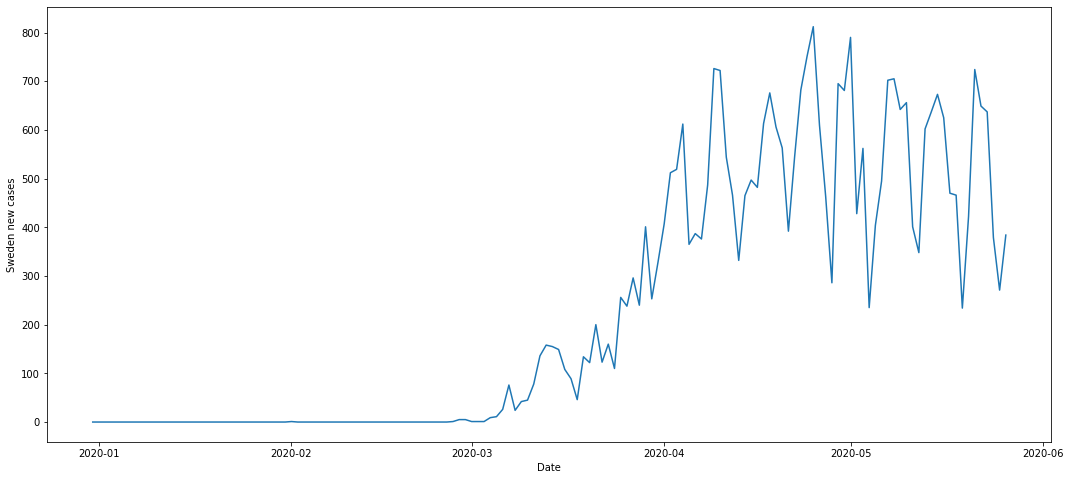

In [140]:
country_series='Sweden'
df_series = df_matrix_new_cases[country_series].copy()

plt.xlabel('Date')
plt.ylabel(country_series+' new cases')
plt.plot(df_series)

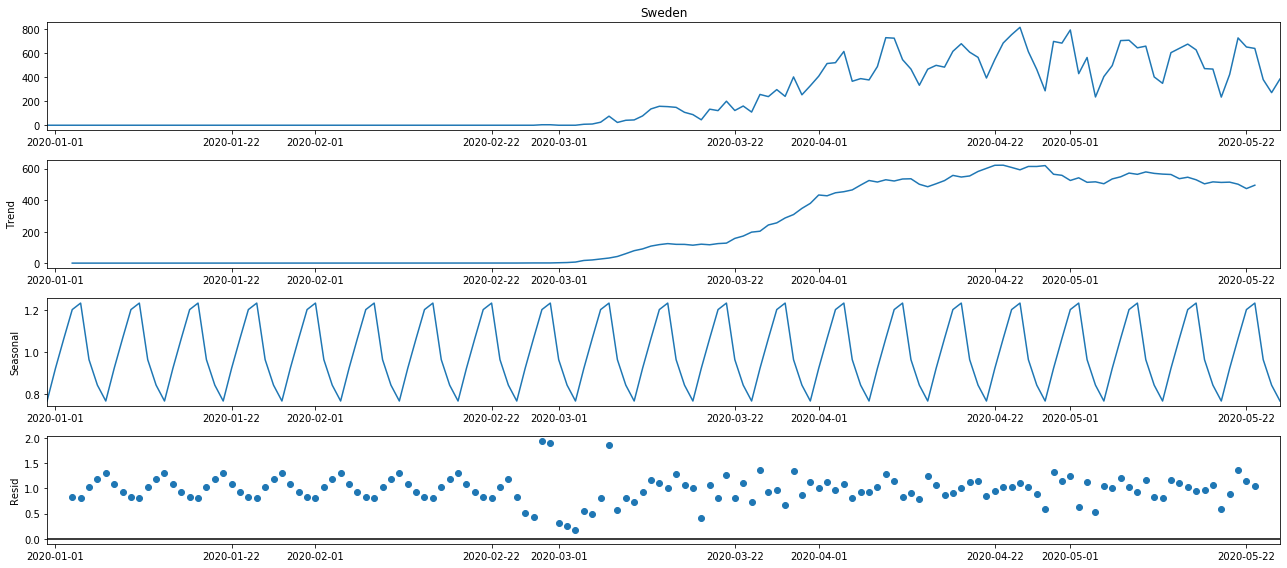

In [141]:
#Decompose the serie
rcParams['figure.figsize'] = 18, 8
df_series = df_series.replace(0, 1)
decomposition = sm.tsa.seasonal_decompose(df_series, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [142]:
stepwise_model = auto_arima(df_series, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1670.601, BIC=1685.127, Fit time=0.743 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1744.873, BIC=1750.684, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1725.641, BIC=1737.262, Fit time=0.253 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1675.051, BIC=1686.672, Fit time=0.512 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1669.019, BIC=1686.451, Fit time=1.292 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=1723.462, BIC=1737.988, Fit time=0.485 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1673.466, BIC=1693.803, Fit time=5.064 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1743.804, BIC=1755.425, Fit time=0.242 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=1641.226, BIC=1664.468, Fit time=4.456 seconds
Fit ARIMA: order=(0, 1, 1) s

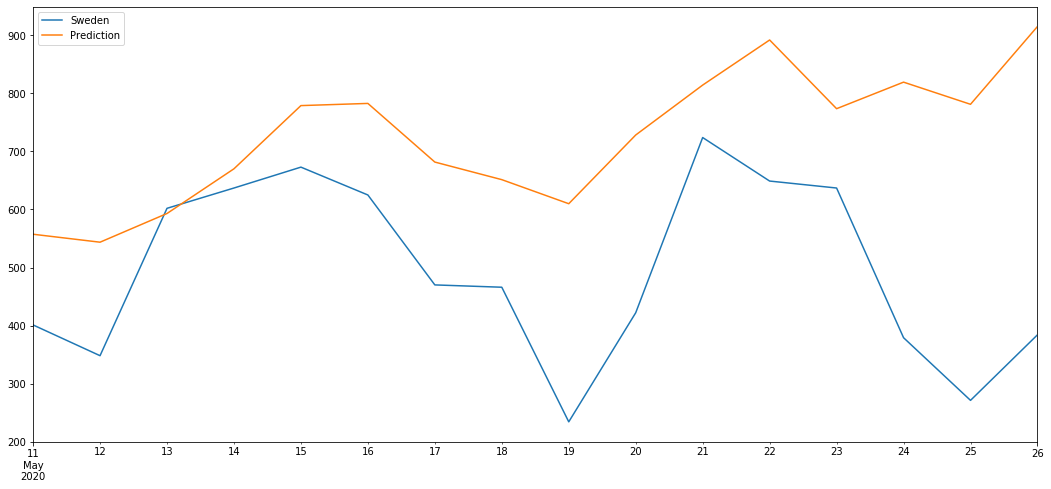

In [143]:
train = df_series.loc['2020-01-01':'2020-05-10']
test = df_series.loc['2020-05-11':]
test_size = len(test)
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=test_size)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
pd.concat([test,future_forecast],axis=1).plot()

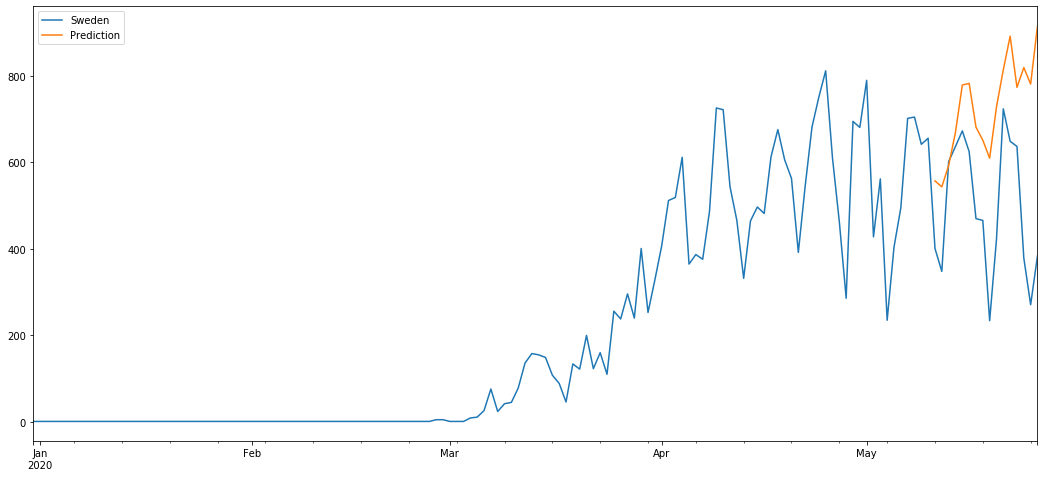

In [144]:
pd.concat([df_series,future_forecast],axis=1).plot()

Now, let's focus on Italy

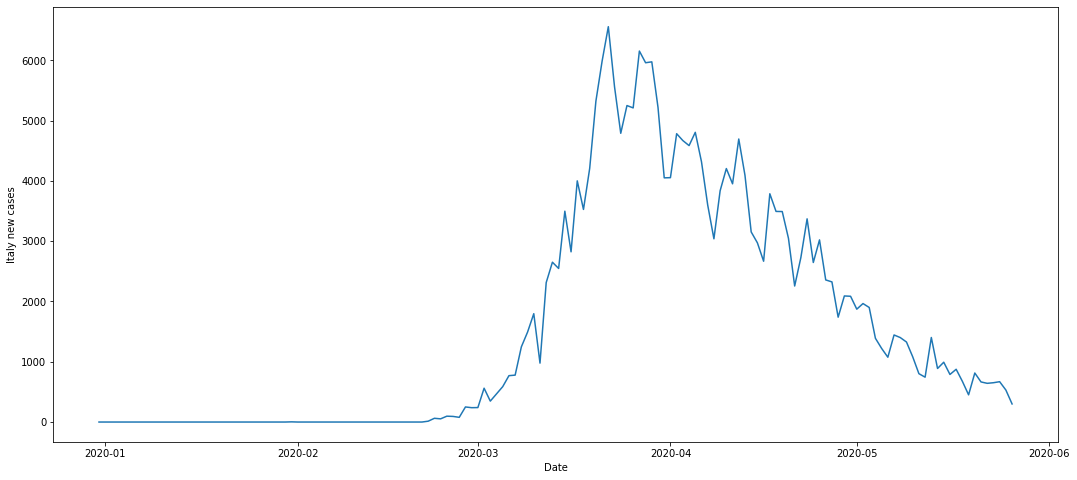

In [135]:
country_series='Italy'
df_series = df_matrix_new_cases[country_series].copy()

plt.xlabel('Date')
plt.ylabel(country_series+' new cases')
plt.plot(df_series)

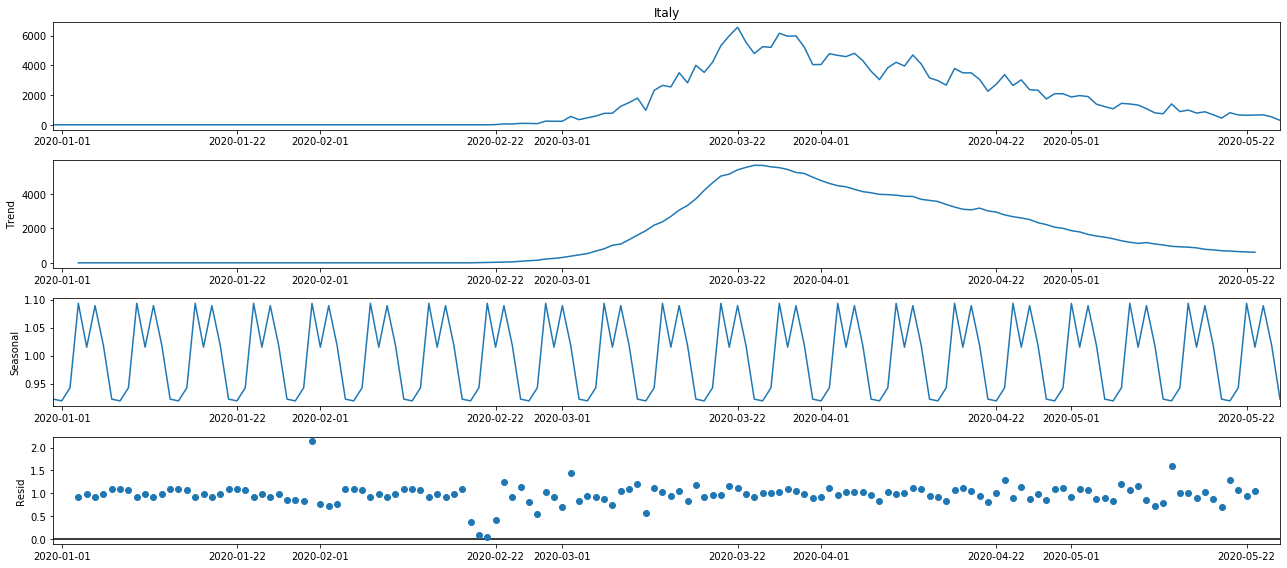

In [136]:
#Decompose the serie
rcParams['figure.figsize'] = 18, 8
df_series = df_series.replace(0, 1)
decomposition = sm.tsa.seasonal_decompose(df_series, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [137]:
stepwise_model = auto_arima(df_series, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2042.593, BIC=2057.120, Fit time=0.981 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2113.469, BIC=2119.280, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2088.402, BIC=2100.023, Fit time=0.333 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2039.840, BIC=2051.461, Fit time=0.736 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2041.701, BIC=2056.227, Fit time=0.693 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2114.209, BIC=2122.925, Fit time=0.036 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2041.623, BIC=2056.149, Fit time=2.511 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2043.839, BIC=2061.271, Fit time=2.822 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=2038.643, BIC=2047.359, Fit time=0.373 seconds
Fit ARIMA: order=(0, 1, 0) s

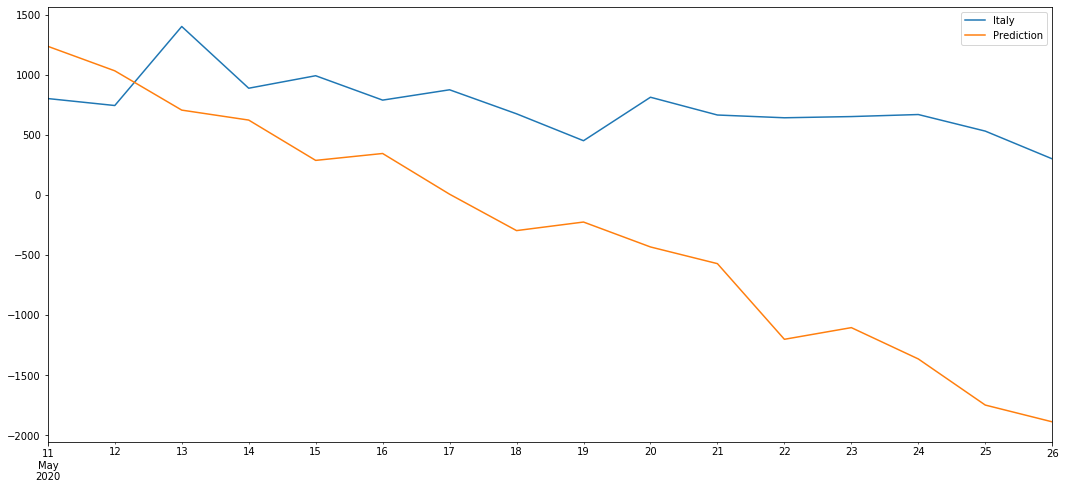

In [138]:
train = df_series.loc['2020-02-27':'2020-05-10']
test = df_series.loc['2020-05-11':]
test_size = len(test)
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=test_size)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
pd.concat([test,future_forecast],axis=1).plot()

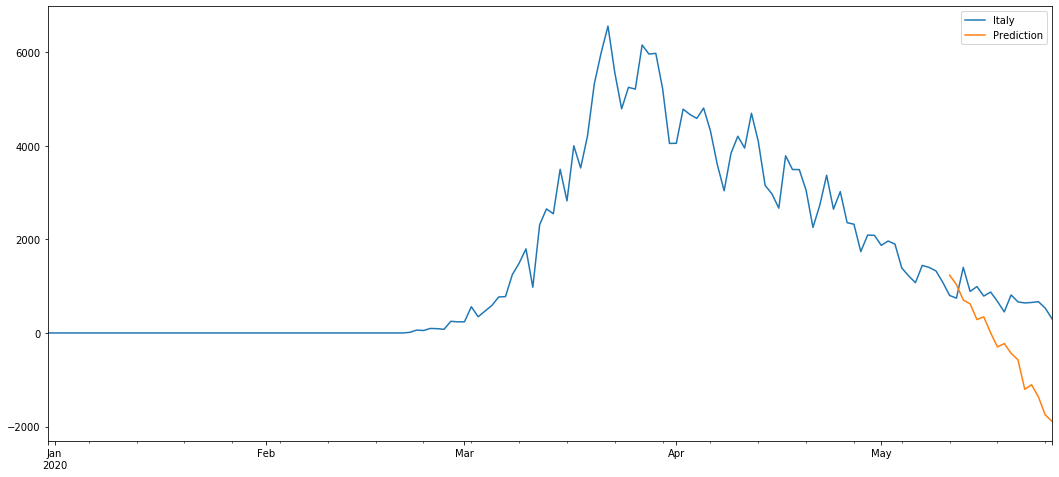

In [139]:
pd.concat([df_series,future_forecast],axis=1).plot()

Looking at these two predictions, they seems not predict very well the number of confirmed cases. We have to try with another model.

## OLD

Firstly, let's plot our series

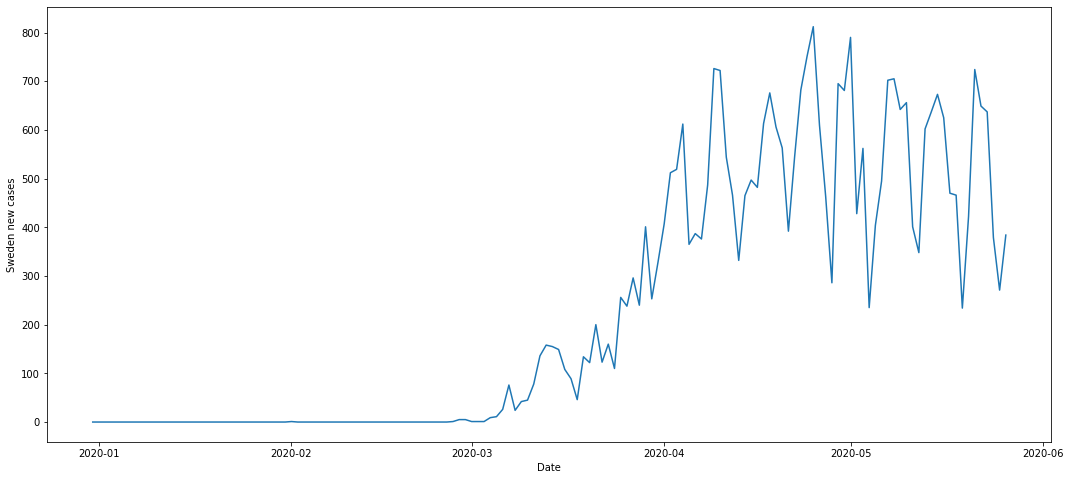

In [53]:
df_series_sweden = df_matrix_new_cases['Sweden'].copy()

plt.xlabel('Date')
plt.ylabel('Sweden new cases')
plt.plot(df_series_sweden)

Now, let's plot with the series the rolling mean and the rolling standard deviation to better understand the trend.

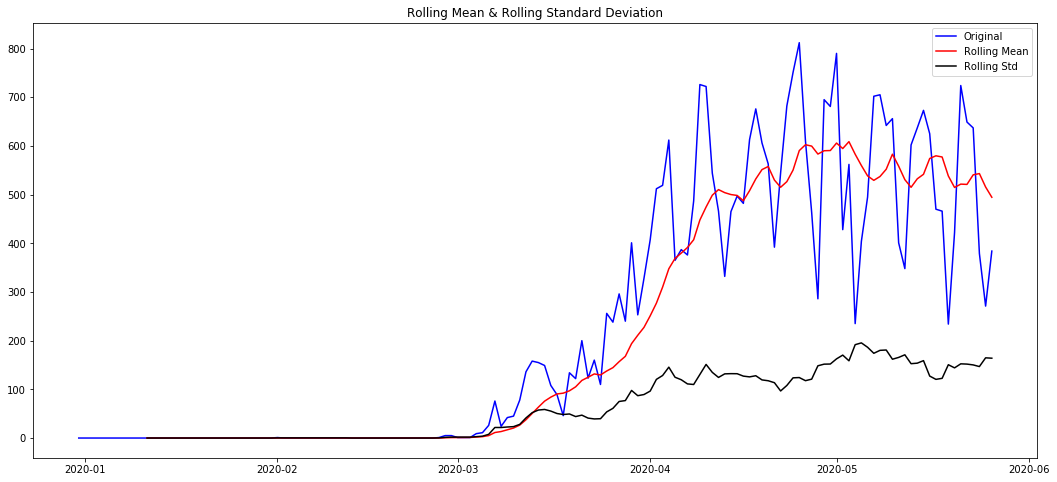

In [54]:
rolling_mean = df_series_sweden.rolling(window = 12).mean()
rolling_std = df_series_sweden.rolling(window = 12).std()
plt.plot(df_series_sweden, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

As it is possible to see, the rolling mean and the rolling standard deviation increase and then decrease, so it is possible to conclude that the series is not stationary. A further test that we can perfom for understanding if the series is stationary is the Dickey-Fuller test. Let's compute it.

In [55]:
dickey_fuller_test = dickeyFuller(df_series_sweden)

ADF Statistic: -0.5208033809835796
p-value: 0.8878925250457099
Critical Values:
	1%: -3.480118600110386
	5%: -2.8833618426136196
	10%: -2.578407034974382


It is possible to see from these last data that the series is not stationary because th p-value is greater than the 5% and the ADF statistic value is greater than the 5% critical value.
Now, for lowering the rate at which the rolling mean increase it is possible to take the logaritm of the dependent variable of the series.

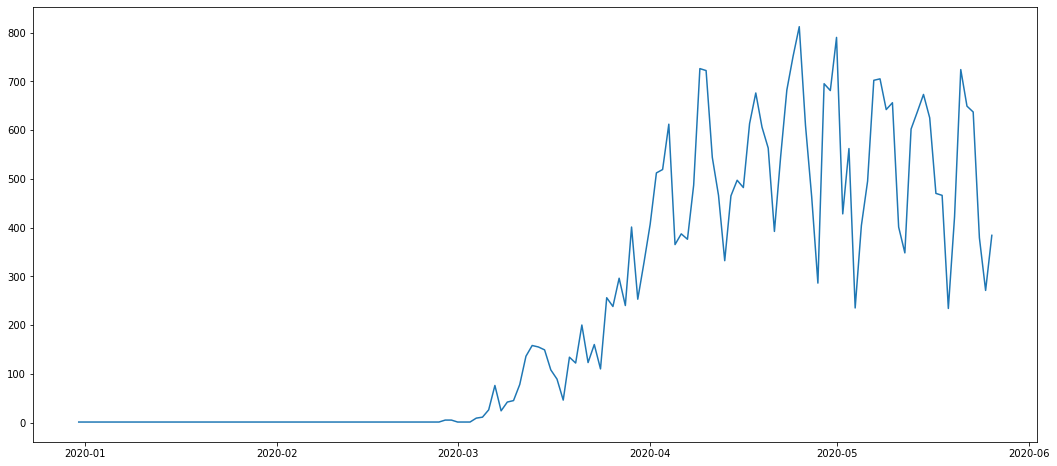

In [56]:
#replace 0 value to avoid error later
df_series_sweden = df_series_sweden.replace(0, 1)
df_series_log = np.log(df_series_sweden)
plt.plot(df_series_sweden)
df_log_shift = df_series_log - df_series_log.shift()
df_log_shift.dropna(inplace=True)

Now, one of the transformation that it is possible to compute to make a series stationary, is to subtract the rolling mean.

In [57]:
rolling_mean = df_series_log.rolling(window=12).mean()
df_series_log_minus_mean = df_series_log - rolling_mean
df_series_log_minus_mean.dropna(inplace=True)

Now we can test the series again with the Dickey-Fuller test to verify if after the transformation the series is stationary.

In [58]:
dickey_fuller_test = dickeyFuller(df_series_log_minus_mean)

ADF Statistic: -3.19749614574903
p-value: 0.020130070366013907
Critical Values:
	1%: -3.4825006939887997
	5%: -2.884397984161377
	10%: -2.578960197753906


Ok, now the series is stationary. We can apply ARIMA model but first we have to set the parameters. To perform this operation the autocorrelation function and partial autocorrelation can be used. So, print the autocorrelation plot.

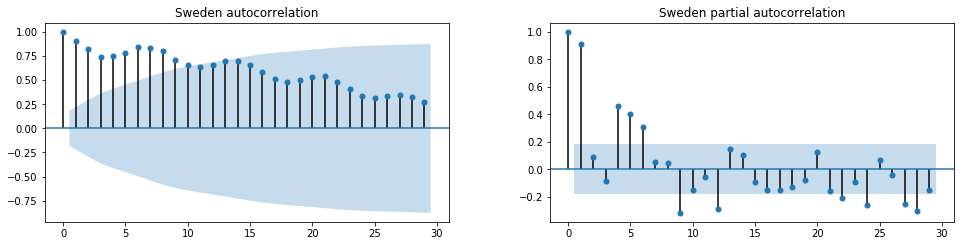

In [59]:
autocorrelationPlot('Sweden',df_matrix_new_cases,29)

We can use ACF to determine the optimal parameter of MA while PACF to determine the optimal parameter for AR. 
QUESTO E' UNO DEI CONCETTI DI CUI ABBIAMO BISOGNO DI UN CHIARIMENTO.

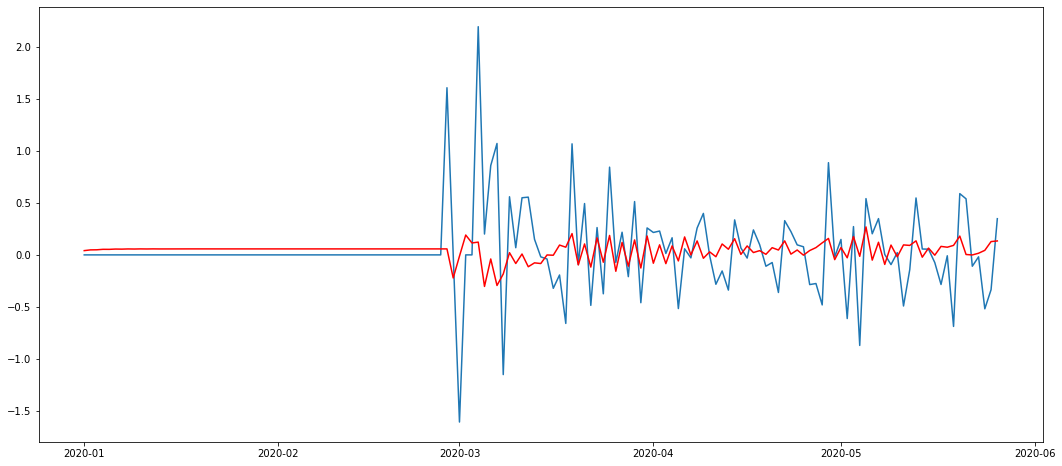

In [60]:
decomposition = seasonal_decompose(df_series_log) 
model = ARIMA(df_series_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

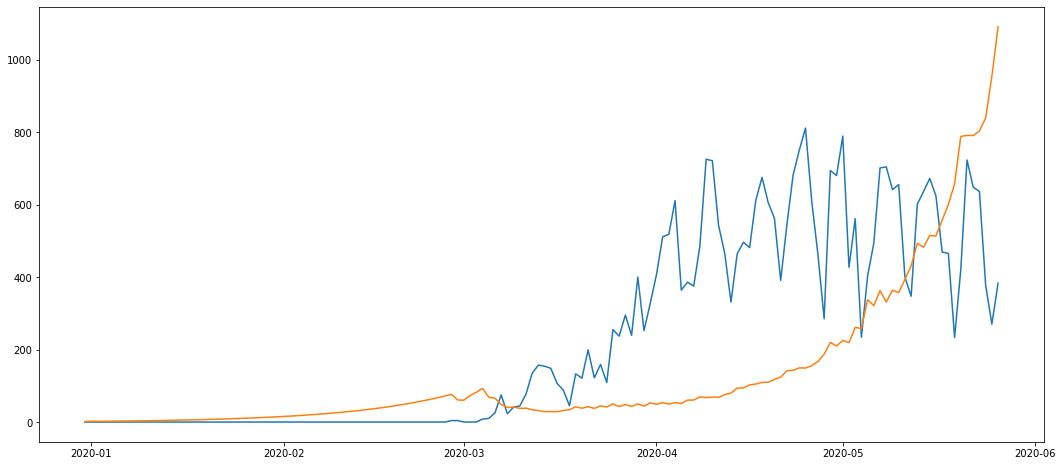

In [61]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_series_sweden.iloc[0], index=df_series_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df_series_sweden)
plt.plot(predictions_ARIMA)

Now, let's try to plot a forecast until the 1st of July 2020

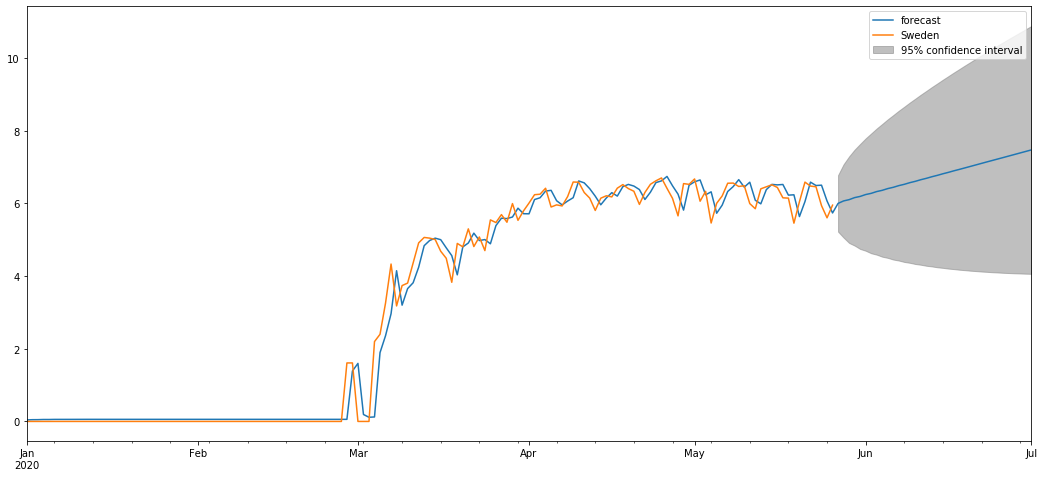

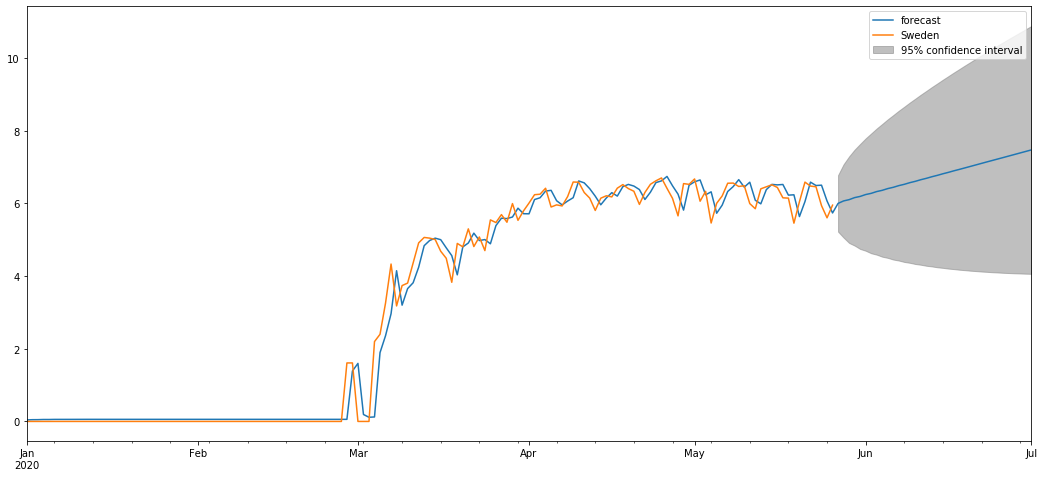

In [62]:
results.plot_predict('2020-01-01','2020-07-01')

Looking at the forecast it seems that the choose done by Sweden politician to avoid the lockdown cuntermeasure will not reward them. The aspectation of the next weeks are of a growing trend.

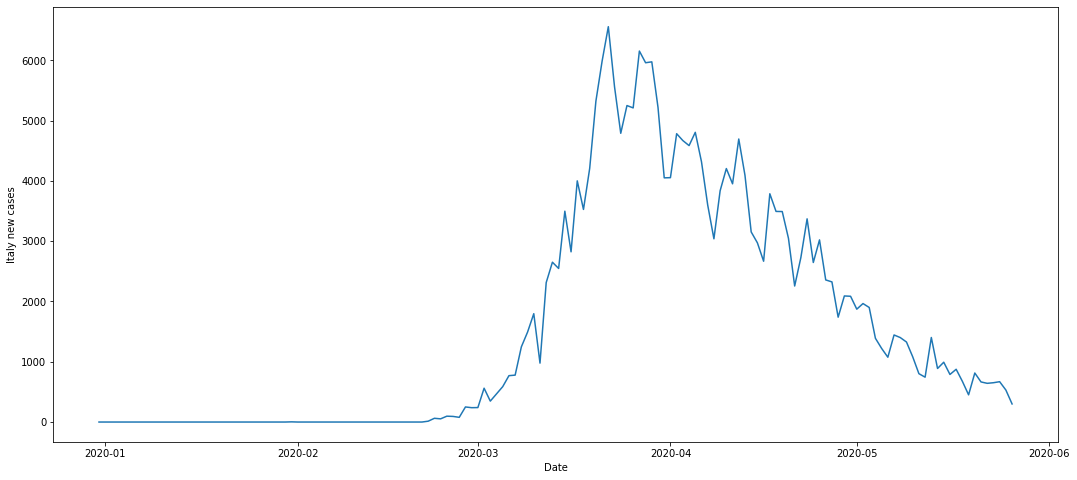

In [63]:
df_series_italy = df_matrix_new_cases['Italy'].copy()

plt.xlabel('Date')
plt.ylabel('Italy new cases')
plt.plot(df_series_italy)

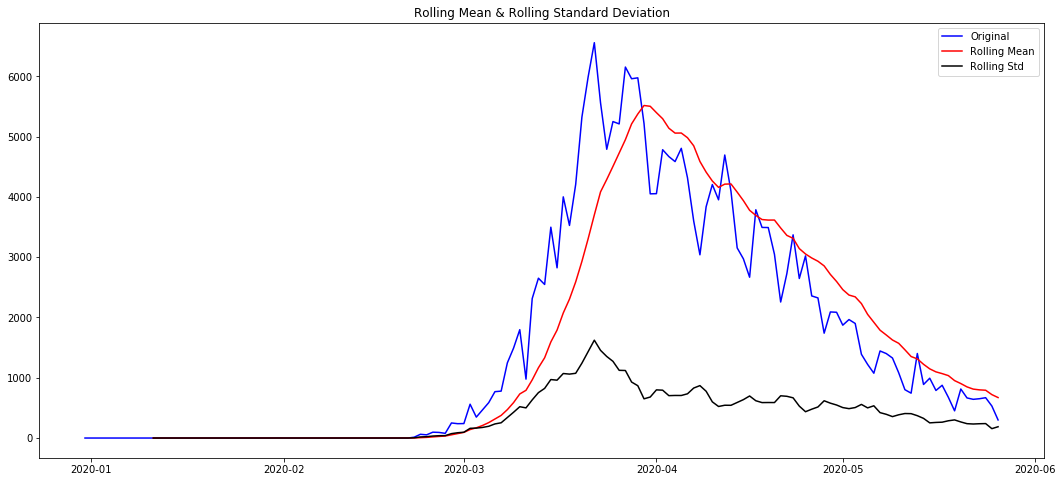

In [64]:
rolling_mean = df_series_italy.rolling(window = 12).mean()
rolling_std = df_series_italy.rolling(window = 12).std()
plt.plot(df_series_italy, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [65]:
dickey_fuller_test = dickeyFuller(df_series_italy)

ADF Statistic: -1.8151355606953359
p-value: 0.37297361973653914
Critical Values:
	1%: -3.479742586699182
	5%: -2.88319822181578
	10%: -2.578319684499314


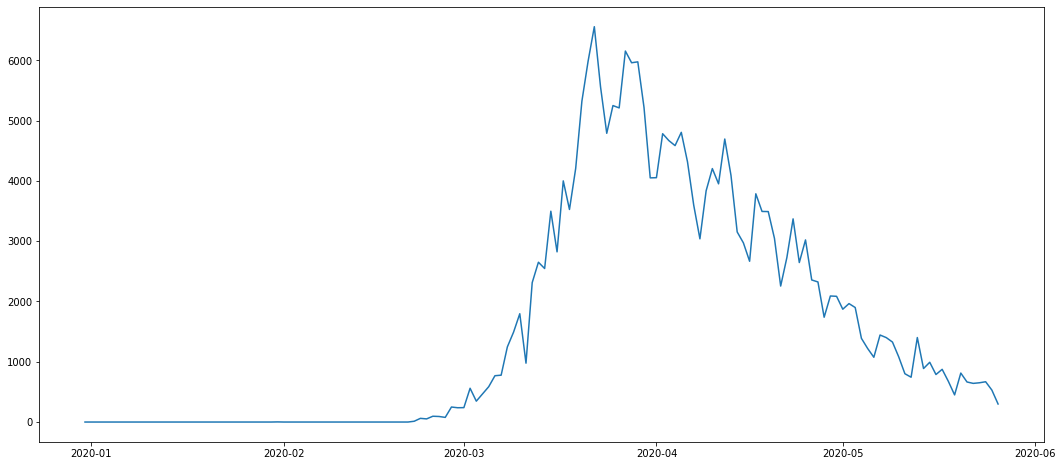

In [66]:
#replace 0 value to avoid error later
df_series_italy = df_series_italy.replace(0, 1)
df_series_log = np.log(df_series_italy)
plt.plot(df_series_italy)
df_log_shift = df_series_log - df_series_log.shift()
df_log_shift.dropna(inplace=True)

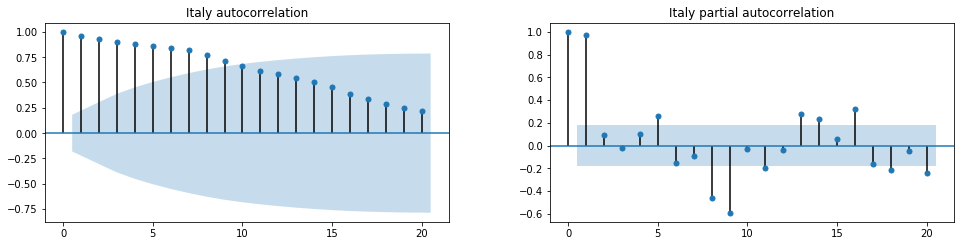

In [67]:
autocorrelationPlot('Italy',df_matrix_new_cases,20)

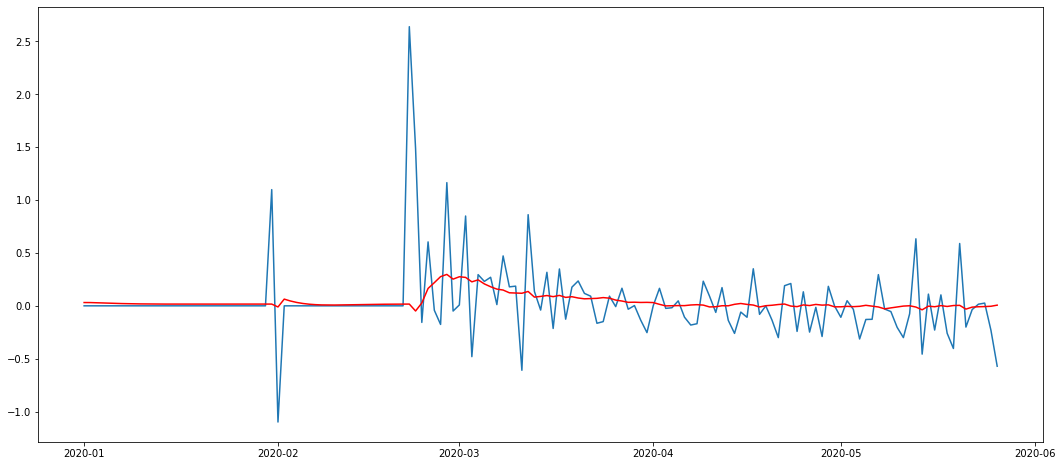

In [68]:
decomposition = seasonal_decompose(df_series_log) 
model = ARIMA(df_series_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

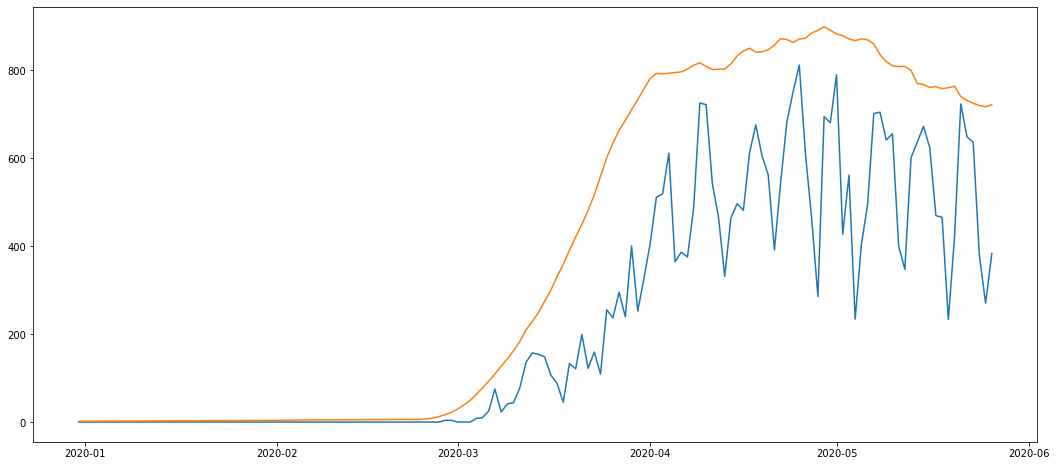

In [69]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_series_sweden.iloc[0], index=df_series_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df_series_sweden)
plt.plot(predictions_ARIMA)

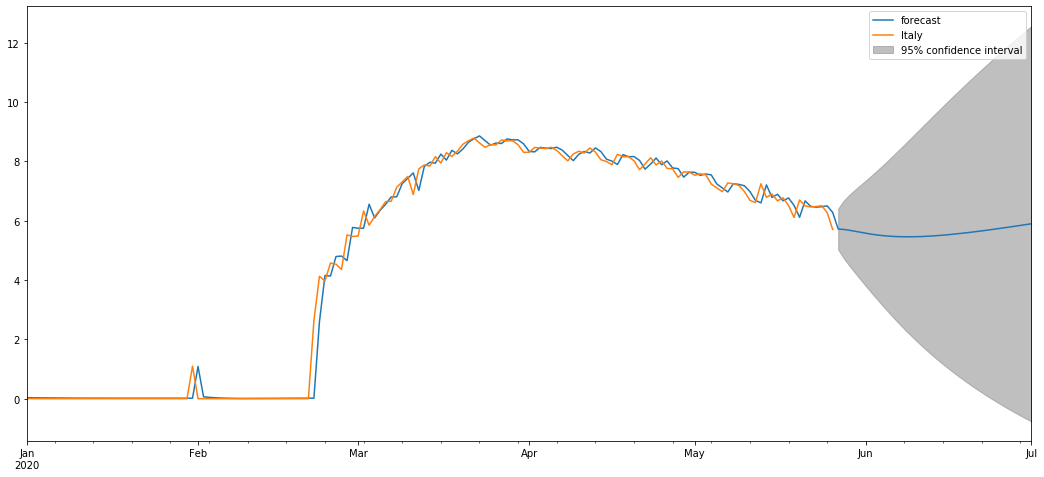

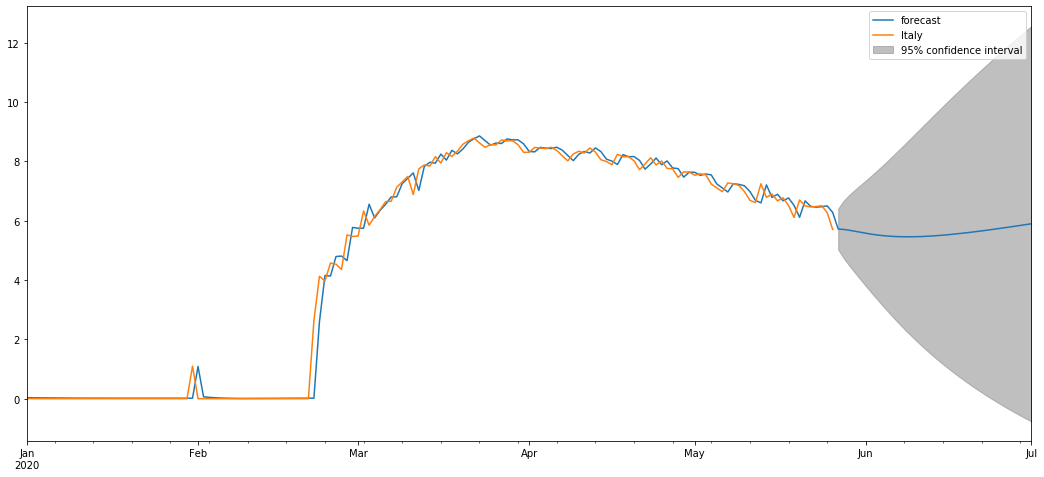

In [70]:
results.plot_predict('2020-01-01','2020-07-01')

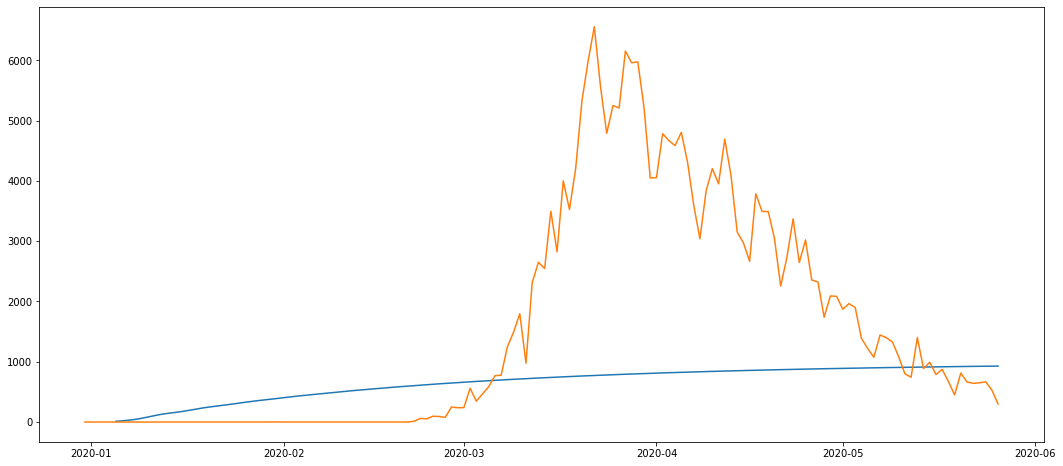

In [71]:
model = ARIMA(df_series_italy, order=(5,0,2))
results = model.fit(disp=-1)
plt.plot( results.predict( dynamic= True)  )
plt.plot(df_series_italy)

# Models

## Correlation between population density and total cases

Now, let's try to see if there is a correlation between the population density in the world countries and the total cases.
Firstly, prepare the dataset with the necessary columns. We have to add a column to store the data of each country about the ratio between the total number of cases and the population.

In [72]:
yesterday = date.today() - timedelta(days=1)

df_regression_friendly=df_all_data[pd.to_datetime(df_all_data['Date'])==pd.to_datetime(yesterday) ].copy()
df_regression_friendly=df_regression_friendly[df_regression_friendly['Lockdown state']==2]
df_regression_friendly['Ratio cases-population']=df_regression_friendly['Total cases']/df_regression_friendly['Population']
del df_regression_friendly['New cases']
del df_regression_friendly['New deaths']
del df_regression_friendly['New cases per million of inhabitants']
del df_regression_friendly['New deaths per million of inhabitants']
df_regression_friendly=df_regression_friendly.reset_index()
del df_regression_friendly['index']
df_regression_friendly.head()

,Date,Country,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state,Ratio cases-population
0,2020-05-25,Afghanistan,10582,218,38928346,48.0,271.832767,5.600032,2020-03-24,2,0.000272
1,2020-05-25,Albania,998,32,2877797,124.6,346.793050,11.119617,2020-03-08,2,0.000347
2,2020-05-25,Algeria,8306,600,43851044,13.8,189.413962,13.682684,2020-03-24,2,0.000189
3,2020-05-25,Andorra,763,51,77265,152.1,9875.105158,660.066007,2020-03-16,2,0.009875
4,2020-05-25,Angola,69,4,32866272,9.7,2.099417,0.121705,2020-03-24,2,0.000002


Let's try to compute a linear regression between the population density and the total cases, to see if there is a linear correlation between these two variables.

Coefficients: 
 [-2.22225672]
Mean squared error: 124445081275.64
Coefficient of determination: -0.04


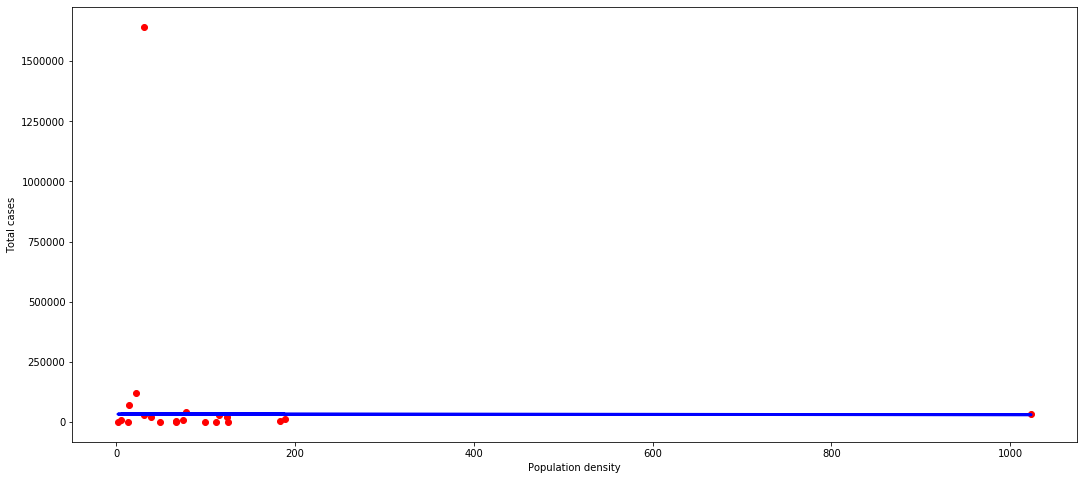

In [73]:
linearRegression(df_regression_friendly['Population density'], df_regression_friendly['Total cases'],'Population density','Total cases')

The statistic descriptions and the graph suggest that there isn't a linea correlation and also, that there isn't any type of correlation.

Now, let's try to compute the same analysis but scaling the total number of cases with the population of each country. In this way, it is possible to see the correlation between the population density and the total number of cases in ratio with the population, that is a more correct way to compare the data.

Coefficients: 
 [3850706.99216811]
Mean squared error: 125194782945.82
Coefficient of determination: -0.03


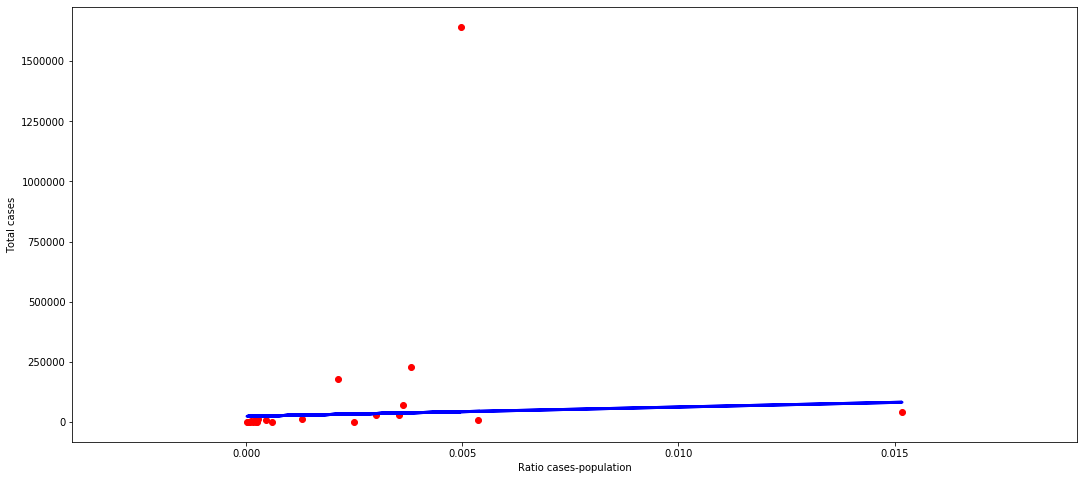

In [74]:
linearRegression(df_regression_friendly['Ratio cases-population'], df_regression_friendly['Total cases'],'Ratio cases-population','Total cases')

At a first glance, no correlation seems to be exist. But before draw this conclusion, let's try to remove the data that seems to be an outlier and then try to compute the regression again. Basing on the last graph, we consider outlier the value greater than 40000 total cases, because, respect to the other countries, their value is very far and could be particular cases of the virus spread.

Coefficients: 
 [-2.95588062]
Mean squared error: 105472342.63
Coefficient of determination: -0.03


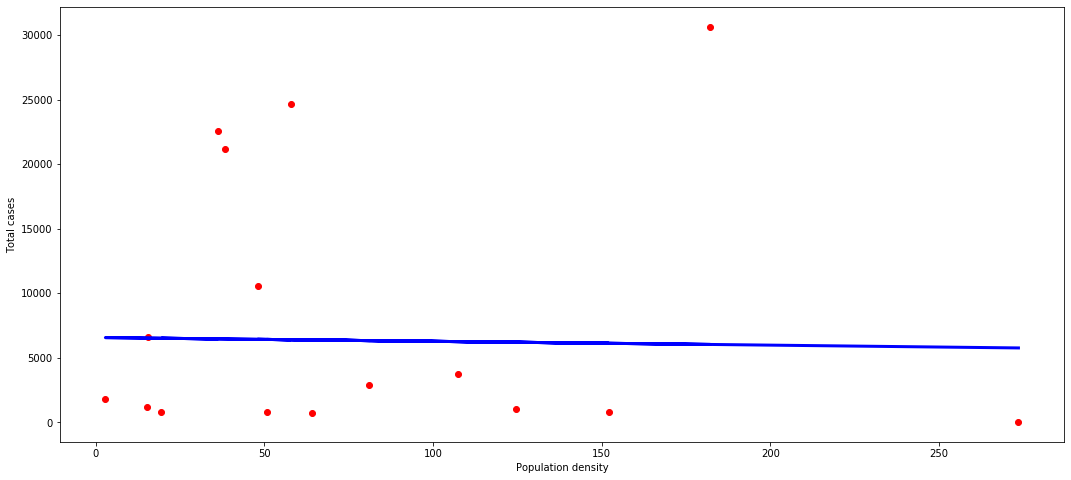

Coefficients: 
 [190121.65498513]
Mean squared error: 74972721.02
Coefficient of determination: -0.01


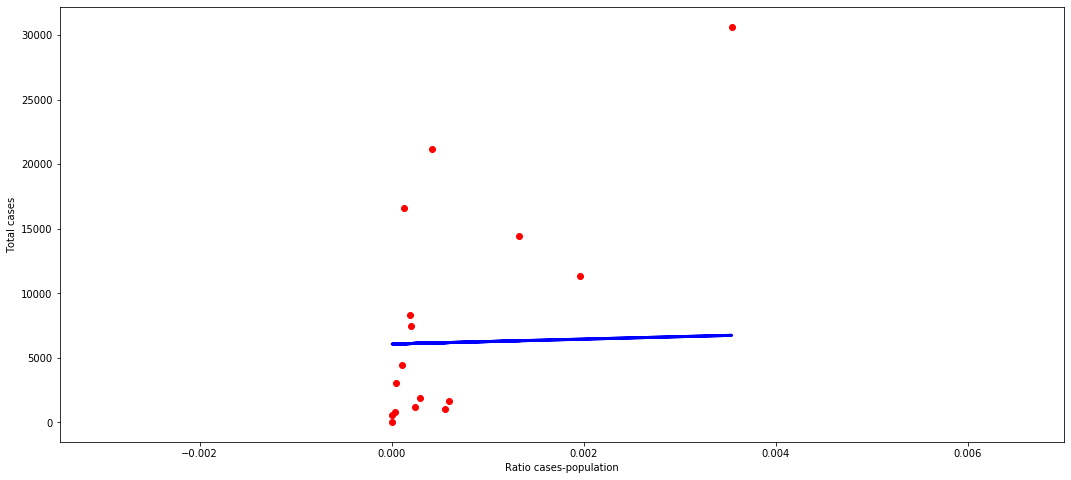

In [75]:
df_regression_friendly_WO=df_regression_friendly[df_regression_friendly['Total cases']<40000]
df_regression_friendly_WO=df_regression_friendly_WO[df_regression_friendly_WO['Population density']<800]

linearRegression(df_regression_friendly_WO['Population density'], df_regression_friendly_WO['Total cases'],'Population density','Total cases')
linearRegression(df_regression_friendly_WO['Ratio cases-population'], df_regression_friendly_WO['Total cases'],'Ratio cases-population','Total cases')


Even without the outliers, no correlation appears to be present between these the population density and the total number of cases.
So, we can conclude that the population density has not a direct impact in term of covid-19 cases. This evaluation was already been done during the visualization phase, where we had note that there were in the top ten countries for total number of cases, countries with a high rate of population density and countries with a low rate of population density.

## World new cases prediction modelling

Now, for each country has been created a polynomial regression model that seems to fit well the trend on the new cases. But first, it is necessary to detect which could be the right degree for the polynomial regression function. Take in example Italy country and try to compute the model with different degrees.
First with degree equal to 3.

In [76]:
array=[]
justNumbers=[]
for country in df_matrix_new_cases.columns:
    for i in range(0,len(df_matrix_new_cases[country])):
            if(df_matrix_new_cases[country][i]>200):
                 array.append((country,len(df_matrix_new_cases[country][i:])))
                 justNumbers.append(len(df_matrix_new_cases[country][i:]))
                 break
print(array)
print("\nNumber of countries with more than 200 cases in a day:",len(array))

[('Afghanistan', 26), ('Argentina', 31), ('Armenia', 10), ('Australia', 66), ('Austria', 72), ('Azerbaijan', 7), ('Bahrain', 43), ('Bangladesh', 42), ('Belarus', 48), ('Belgium', 69), ('Bolivia', 24), ('Brazil', 67), ('Cameroon', 53), ('Canada', 66), ('Chile', 62), ('China', 124), ('Colombia', 49), ('Denmark', 76), ('Djibouti', 6), ('Dominican Republic', 56), ('Ecuador', 67), ('Egypt', 52), ('Finland', 52), ('France', 79), ('Gabon', 3), ('Germany', 81), ('Ghana', 37), ('Guatemala', 5), ('Guinea', 5), ('Honduras', 19), ('Hungary', 47), ('India', 55), ('Indonesia', 50), ('Iran', 87), ('Iraq', 3), ('Ireland', 64), ('Israel', 68), ('Italy', 89), ('Japan', 55), ('Kazakhstan', 43), ('Kuwait', 32), ('Luxembourg', 63), ('Malaysia', 64), ('Mexico', 52), ('Moldova', 42), ('Morocco', 52), ('Netherlands', 71), ('Nicaragua', 4), ('Nigeria', 26), ('Norway', 76), ('Oman', 43), ('Pakistan', 59), ('Panama', 48), ('Peru', 55), ('Philippines', 59), ('Poland', 59), ('Portugal', 67), ('Qatar', 76), ('Roman

In [77]:
filtered_new_cases=pd.DataFrame()
array.sort(key = lambda x: x[1],reverse=True) 

for couple in array:
    for i in range(0,len(df_matrix_new_cases[couple[0]])):
            if(df_matrix_new_cases[couple[0]][i]>200):
                 if (couple[1]>=50):
                     filtered_new_cases[couple[0]]=np.array(df_matrix_new_cases[couple[0]][i:i+50])
                     break

filtered_new_cases.head()

,China,Italy,Iran,Germany,Spain,France,United States,Denmark,Norway,Qatar,...,Japan,Peru,Ukraine,United Arab Emirates,Cameroon,Egypt,Finland,Mexico,Morocco,Indonesia
0,259,250,205,284,233,410,271,252,212,238,...,225,258,245,360,238,206,267,202,211,218
1,441,238,385,163,330,286,287,160,132,0,...,439,91,10,0,46,85,45,253,102,247
2,665,240,523,55,433,372,351,128,0,58,...,318,181,183,481,95,3,249,296,99,218
3,787,561,835,237,772,497,511,23,286,17,...,336,151,109,294,8,249,132,346,64,337
4,1753,347,586,157,975,595,777,48,170,64,...,383,535,155,277,27,238,179,396,91,219


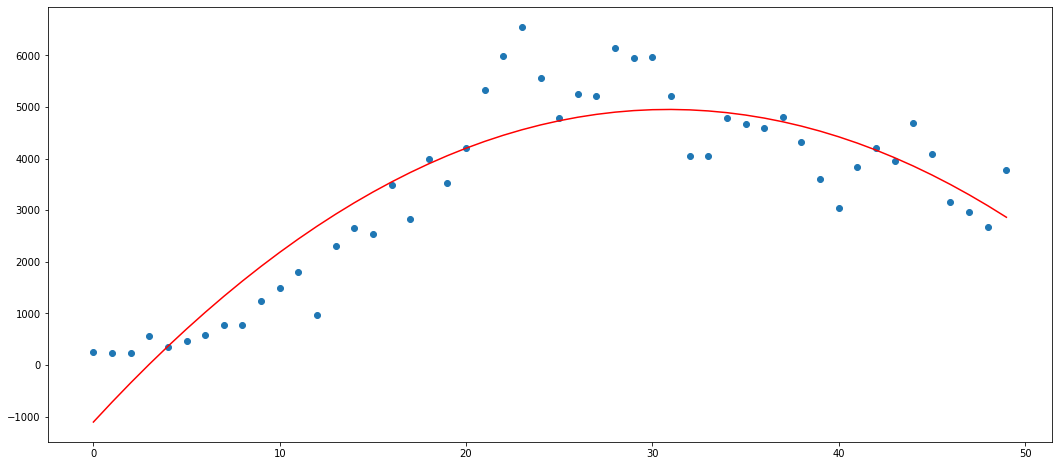

In [78]:
poly_features=PolynomialFeatures(degree=2,include_bias=False)
x_poly=poly_features.fit_transform(np.array(filtered_new_cases.index).reshape(-1, 1))

linear_reg=LinearRegression()

linear_reg.fit(x_poly,filtered_new_cases['Italy'])
predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
plt.plot(predI,color='red')

Now try with degree equal to 4.

Italy


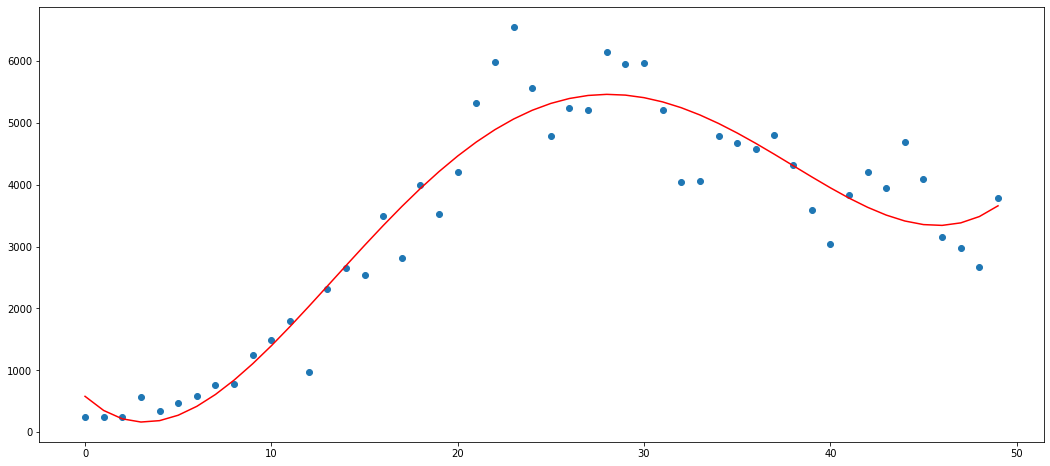

In [79]:
poly_features = PolynomialFeatures(degree=4,include_bias=False)
x_poly=poly_features.fit_transform(np.array(filtered_new_cases.index).reshape(-1, 1))

linear_reg=LinearRegression()
linear_reg.fit(x_poly,filtered_new_cases['Italy'])
predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
print("Italy")
plt.plot(predI,color='red')

Italy


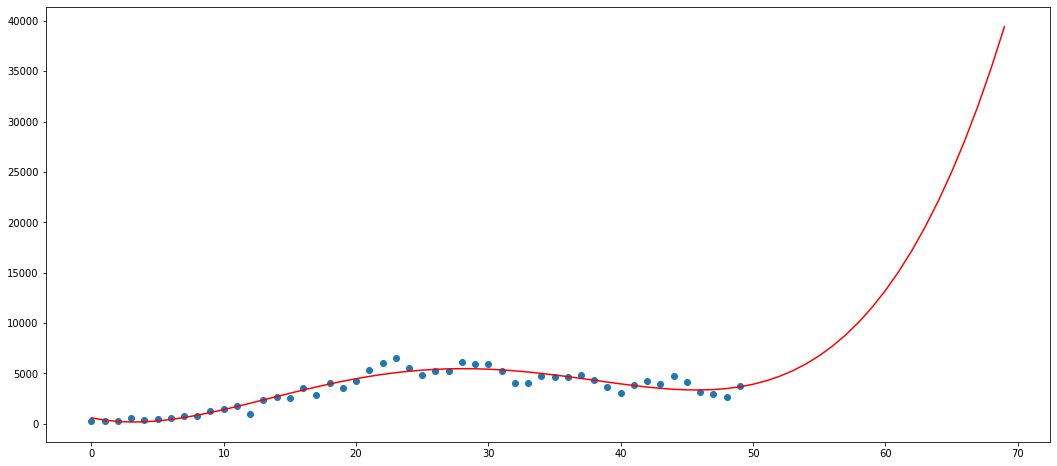

In [80]:

x_poly=poly_features.fit_transform(np.array(range(0,70)).reshape(-1, 1))



predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
print("Italy")
plt.plot(predI,color='red')

In [81]:


for i in range(0,len(df_matrix_new_cases['Italy'])):
        if(df_matrix_new_cases['Italy'][i]>200):
                 
                     italy_cases=np.array(df_matrix_new_cases['Italy'][i:])
                     italy_dates=np.array(df_matrix_new_cases.index[i:])
                     break

italy_cases
italy_dates
italy_set=pd.DataFrame()
italy_set['New cases']=italy_cases
italy_set.set_index(italy_dates)

,New cases
2020-02-28,250
2020-02-29,238
2020-03-01,240
2020-03-02,561
2020-03-03,347
...,...
2020-05-22,642
2020-05-23,652
2020-05-24,669
2020-05-25,531


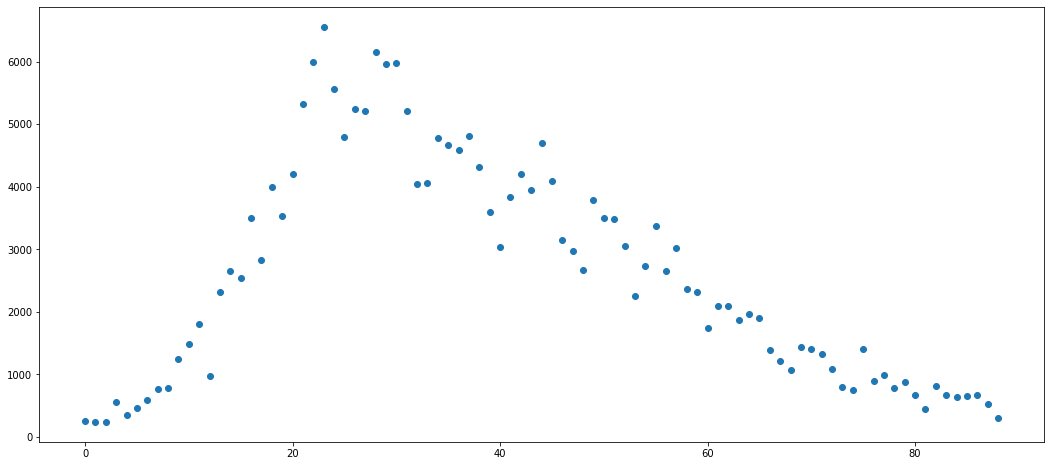

In [82]:
plt.scatter(italy_set.index,italy_set['New cases'])

In [83]:
Italy_set_am=pd.DataFrame()
window=10
Italy_set_am['New cases am']=moving_mean(italy_set['New cases'],window)
Italy_set_am=Italy_set_am.set_index(italy_dates[window-1:])

Italy_set_am

,New cases am
2020-03-08,523.3
2020-03-09,648.7
2020-03-10,804.4
2020-03-11,846.0
2020-03-12,1042.6
...,...
2020-05-22,679.0
2020-05-23,655.4
2020-05-24,623.1
2020-05-25,597.3


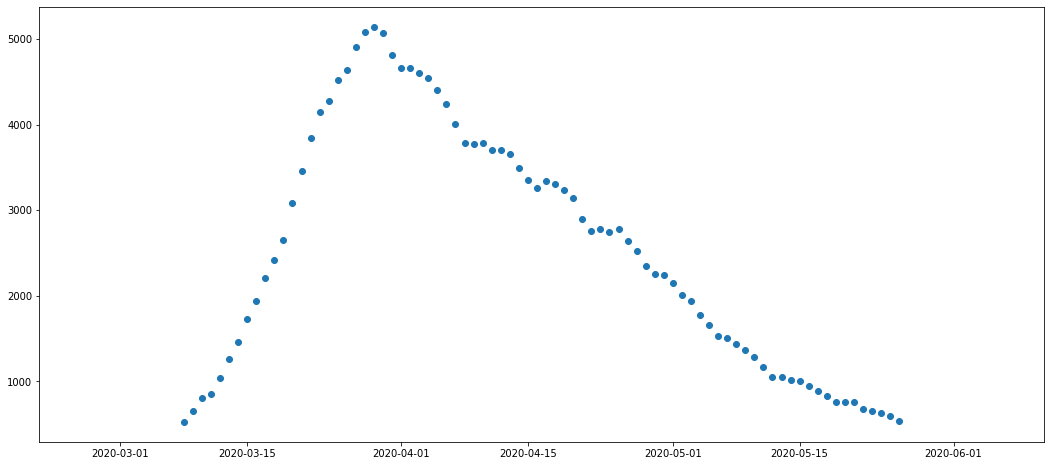

In [84]:
plt.scatter(italy_dates[window-1:],Italy_set_am['New cases am'])

Linear Regression Model Score: 0.9872373049323668


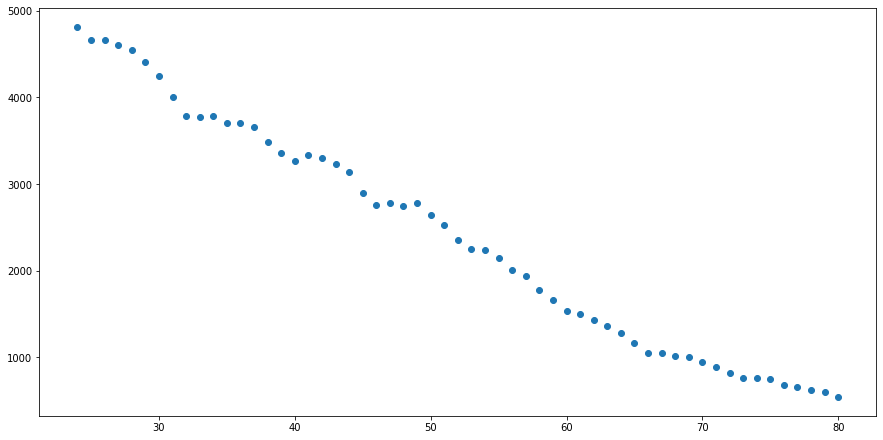

In [95]:

X, y, peak_date, linear_regr = curveAfterPeak(italy_dates,Italy_set_am['New cases am'])

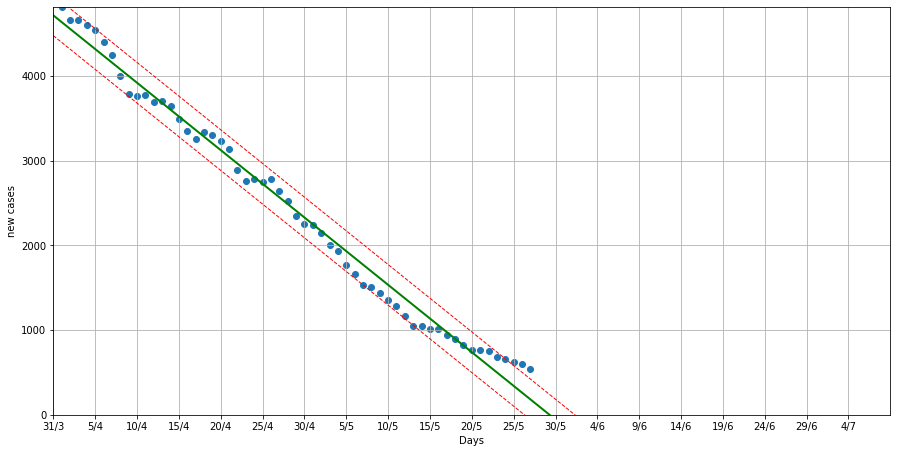

In [107]:
X_train=X[0:40]

y_train=y[0:40]

predictTrain(X, y, X_train,y_train,peak_date,Italy_set_am.index, linear_regr)

regressione lineare sulla densità di popolazione: inserire filtro sui paesi che hanno superato i 200 casi e che al superamento hanno avuto una crescita superiore ad un certo valore, considerando un certo intervallo di tempo (1 settimana). Utilizzare la funzione per calcolare la crescita

La funzione per fare la valutazione della predizione del modello di regressione è:
R2_score(y_test,y_pred)
dove y_test sono i dati che hai tenuto da parte per il test
mentre y_pred sono i dati che ha predetto il modello. prova a vedere cosa esce
per fare il training del modello usa il 70% dei dati. Il 30% rimanente per il test.
Poi esegui questo algoritmo per i seguenti paesi: Italia, Cina, Svezia, USA